# Wind & Solar Energy Production | Comprehensive EDA & Forecasting

> **Dataset:** [Wind and Solar Energy Production Dataset](https://www.kaggle.com/datasets/ahmeduzaki/wind-and-solar-energy-production-dataset)
> **Period:** January 2020 - November 2025 | **Records:** 51,864 hourly measurements
> **Author:** Sajjad Khan Yousafzai | **Tools:** Python, Pandas, Seaborn, Plotly, Statsmodels, TensorFlow

---

## Table of Contents

| # | Section | Description |
|---|---------|-------------|
| 1 | Setup & Imports | Libraries, plotting configuration |
| 2 | Data Loading & First Look | Shape, dtypes, head |
| 3 | Data Quality Assessment | Missing values, duplicates |
| 4 | Feature Engineering | Date parsing, cyclical encoding |
| 5 | Descriptive Statistics | Summary stats, unique values |
| 6 | Distribution Analysis | Histograms, box plots, violins |
| 7 | Energy Source Analysis | Wind vs Solar deep dive |
| 8 | Temporal Patterns | Hourly, daily, monthly, seasonal, yearly |
| 9 | Heatmaps & Cross-tabs | Hour x Month, Year x Month |
| 10 | Correlation & Variability | Feature relationships, CV% |
| 11 | Time-Series Deep Dive | Rolling stats, decomposition, cumulative |
| 12 | Peak Production & Summary | Top periods, final conclusions |
| 13 | Forecasting | ARIMA, Prophet, LSTM |
| 14 | Save Models | Export trained models for dashboard |

In [1]:
# =====================================================================
# 1. SETUP & IMPORTS
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
import warnings, os, joblib

warnings.filterwarnings("ignore")

# Premium plotting configuration
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.facecolor": "#fdfdfd",
    "axes.facecolor":   "#fdfdfd",
    "axes.edgecolor":   "#2b2b2b",
    "axes.linewidth":   1.8,
    "axes.titlesize":   17,
    "axes.titleweight": "bold",
    "axes.labelsize":   14,
    "axes.labelweight": "bold",
    "xtick.labelsize":  12,
    "ytick.labelsize":  12,
    "legend.fontsize":  12,
    "figure.titlesize": 20,
    "figure.dpi":       120,
    "savefig.dpi":      300,
    "font.family":      "sans-serif",
})

# Color palette
COLORS = {
    "wind": "#1f77b4", "solar": "#ff7f0e", "mixed": "#2ca02c",
    "accent": "#E8D44D", "cyan": "#4CC9F0", "pink": "#F72585", "purple": "#7209B7",
}
SEASON_COLORS = {"Winter": "#1e90ff", "Spring": "#32cd32", "Summer": "#ff4500", "Fall": "#9370db"}

# Create models directory
os.makedirs("models", exist_ok=True)

print("Setup complete - all libraries loaded.")

Setup complete - all libraries loaded.


---
## 2. Data Loading & First Look

In [2]:
df = pd.read_csv("Dataset/Energy Production Dataset.csv")
print(f"Shape : {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")
df.head(10)

Shape : 51,864 rows x 9 columns
Memory: 17.26 MB



Date  Start_Hour  End_Hour Source  Day_of_Year Day_Name Month_Name  \
0  11/30/2025          21        22   Wind          334   Sunday   November   
1  11/30/2025          18        19   Wind          334   Sunday   November   
2  11/30/2025          16        17   Wind          334   Sunday   November   
3  11/30/2025          23         0   Wind          334   Sunday   November   
4  11/30/2025           6         7   Wind          334   Sunday   November   
5  11/30/2025           4         5   Wind          334   Sunday   November   
6  11/30/2025           5         6   Wind          334   Sunday   November   
7  11/30/2025           8         9   Wind          334   Sunday   November   
8  11/30/2025          12        13   Wind          334   Sunday   November   
9  11/30/2025          15        16   Wind          334   Sunday   November   

  Season  Production  
0   Fall        5281  
1   Fall        3824  
2   Fall        3824  
3   Fall        6120  
4   Fall        4387  
5   Fall        4231  
6   Fall        4365  
7   Fall        4801  
8   Fall        7737  
9   Fall        5584

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51864 entries, 0 to 51863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         51864 non-null  object
 1   Start_Hour   51864 non-null  int64 
 2   End_Hour     51864 non-null  int64 
 3   Source       51864 non-null  object
 4   Day_of_Year  51864 non-null  int64 
 5   Day_Name     51864 non-null  object
 6   Month_Name   51864 non-null  object
 7   Season       51864 non-null  object
 8   Production   51864 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ MB


---
## 3. Data Quality Assessment

In [4]:
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing cells : {df.isnull().sum().sum()}")
print(f"Duplicate rows      : {df.duplicated().sum()}")

Missing values per column:
Date           0
Start_Hour     0
End_Hour       0
Source         0
Day_of_Year    0
Day_Name       0
Month_Name     0
Season         0
Production     0
dtype: int64

Total missing cells : 0
Duplicate rows      : 0


### Key Observation - Data Quality

| Check | Result |
|-------|--------|
| Missing Values | **0** across all 9 columns |
| Duplicate Rows | **0** - every record is unique |
| Data Completeness | **100%** - production-grade quality |

> The dataset is remarkably clean, typical of well-curated energy telemetry pipelines. No imputation or deduplication is needed.

---
## 4. Feature Engineering

In [5]:
# Parse Date
df["Date"] = pd.to_datetime(df["Date"], format="mixed")

# Extract temporal features
df["Year"]    = df["Date"].dt.year
df["Month"]   = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter
df["Week"]    = df["Date"].dt.isocalendar().week.astype(int)
df["IsWeekend"] = df["Day_Name"].isin(["Saturday", "Sunday"]).astype(int)

# Cyclical encoding (helps ML models understand circular nature of hours / day-of-year)
df["Hour_sin"] = np.sin(2 * np.pi * df["Start_Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Start_Hour"] / 24)
df["DoY_sin"]  = np.sin(2 * np.pi * df["Day_of_Year"] / 366)
df["DoY_cos"]  = np.cos(2 * np.pi * df["Day_of_Year"] / 366)

# Set ordered categoricals
month_order  = ["January","February","March","April","May","June",
                "July","August","September","October","November","December"]
day_order    = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
season_order = ["Winter","Spring","Summer","Fall"]

df["Month_Name"] = pd.Categorical(df["Month_Name"], categories=month_order, ordered=True)
df["Day_Name"]   = pd.Categorical(df["Day_Name"],   categories=day_order,   ordered=True)
df["Season"]     = pd.Categorical(df["Season"],      categories=season_order, ordered=True)

print(f"Feature engineering complete - {df.shape[1]} columns now available.")
print(f"New features: Year, Month, Quarter, Week, IsWeekend, Hour_sin/cos, DoY_sin/cos")
df.head(3)

Feature engineering complete - 18 columns now available.
New features: Year, Month, Quarter, Week, IsWeekend, Hour_sin/cos, DoY_sin/cos


Date  Start_Hour  End_Hour Source  Day_of_Year Day_Name Month_Name  \
0 2025-11-30          21        22   Wind          334   Sunday   November   
1 2025-11-30          18        19   Wind          334   Sunday   November   
2 2025-11-30          16        17   Wind          334   Sunday   November   

  Season  Production  Year  Month  Quarter  Week  IsWeekend  Hour_sin  \
0   Fall        5281  2025     11        4    48          1 -0.707107   
1   Fall        3824  2025     11        4    48          1 -1.000000   
2   Fall        3824  2025     11        4    48          1 -0.866025   

       Hour_cos   DoY_sin   DoY_cos  
0  7.071068e-01 -0.522133  0.852864  
1 -1.836970e-16 -0.522133  0.852864  
2 -5.000000e-01 -0.522133  0.852864

### Why Cyclical Encoding?

Hours (0-23) and Day-of-Year (1-366) are **cyclical**: hour 23 is close to hour 0, and Dec 31 is close to Jan 1. Standard integer encoding creates an artificial "distance" between these values. Sine/cosine transforms preserve the circular relationship, which significantly improves performance for regression and neural network models.

---
## 5. Descriptive Statistics

In [6]:
df.describe()

Date    Start_Hour      End_Hour  \
count                          51864  51864.000000  51864.000000   
mean   2022-12-16 00:35:34.012031488     11.500000     11.500000   
min              2020-01-01 00:00:00      0.000000      0.000000   
25%              2021-06-24 00:00:00      5.750000      5.750000   
50%              2022-12-16 00:00:00     11.500000     11.500000   
75%              2024-06-08 00:00:00     17.250000     17.250000   
max              2025-11-30 00:00:00     23.000000     23.000000   
std                              NaN      6.922253      6.922253   

        Day_of_Year    Production          Year         Month       Quarter  \
count  51864.000000  51864.000000  51864.000000  51864.000000  51864.000000   
mean     180.798415   6215.069933   2022.463674      6.444123      2.487159   
min        1.000000     58.000000   2020.000000      1.000000      1.000000   
25%       91.000000   3111.000000   2021.000000      3.000000      1.000000   
50%      181.000000   5372.000000   2022.000000      6.000000      2.000000   
75%      271.000000   8501.000000   2024.000000      9.000000      3.000000   
max      366.000000  23446.000000   2025.000000     12.000000      4.000000   
std      104.291387   3978.364965      1.693759      3.410249      1.110704   

               Week     IsWeekend      Hour_sin      Hour_cos       DoY_sin  \
count  51864.000000  51864.000000  5.186400e+04  5.186400e+04  51864.000000   
mean      26.302001      0.285979 -1.135825e-17 -6.299912e-17      0.003626   
min        1.000000      0.000000 -1.000000e+00 -1.000000e+00     -0.999963   
25%       13.000000      0.000000 -7.071068e-01 -7.071068e-01     -0.713130   
50%       26.000000      0.000000  6.123234e-17 -6.123234e-17      0.017166   
75%       39.000000      1.000000  7.071068e-01  7.071068e-01      0.710135   
max       53.000000      1.000000  1.000000e+00  1.000000e+00      0.999963   
std       14.893448      0.451884  7.071136e-01  7.071136e-01      0.711852   

            DoY_cos  
count  51864.000000  
mean      -0.015452  
min       -1.000000  
25%       -0.716152  
50%       -0.025748  
75%        0.679273  
max        1.000000  
std        0.702164

In [7]:
print("=" * 60)
print("UNIQUE VALUES PER COLUMN")
print("=" * 60)
for col in df.columns:
    n = df[col].nunique()
    line = f"  {col:15s} -> {n:>6,} unique"
    if n <= 12:
        vals = sorted(df[col].dropna().unique()) if df[col].dtype.name == 'category' else df[col].unique()
        line += f"  | {list(vals)}"
    print(line)

UNIQUE VALUES PER COLUMN
  Date            ->  2,161 unique
  Start_Hour      ->     24 unique
  End_Hour        ->     24 unique
  Source          ->      3 unique  | ['Wind', 'Solar', 'Mixed']
  Day_of_Year     ->    366 unique
  Day_Name        ->      7 unique  | ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
  Month_Name      ->     12 unique  | ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
  Season          ->      4 unique  | ['Fall', 'Spring', 'Summer', 'Winter']
  Production      -> 14,617 unique
  Year            ->      6 unique  | [2025, 2024, 2023, 2022, 2021, 2020]
  Month           ->     12 unique  | [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 12]
  Quarter         ->      4 unique  | [4, 3, 2, 1]
  Week            ->     53 unique
  IsWeekend       ->      2 unique  | [1, 0]
  Hour_sin        ->     21 unique
  Hour_cos        ->     22 unique
  DoY_sin         ->    32

### Key Observation - Descriptive Statistics

| Metric | Value |
|--------|-------|
| Mean Production | **6,215 MWh** |
| Median Production | **5,372 MWh** (mean > median = right-skewed) |
| Std Deviation | **3,978 MWh** (64% of mean = high variability) |
| IQR | **5,390 MWh** (Q3 - Q1) |
| Min / Max | **58 - 23,446 MWh** (400x range!) |
| Skewness | **~0.93** - moderate positive skew |

> The large coefficient of variation (CV ~ 64%) tells us energy production is inherently **volatile** - driven by weather conditions, daylight hours, and seasonal wind patterns. This is a hallmark of renewable energy datasets and a key challenge for grid operators.

---
## 6. Distribution Analysis

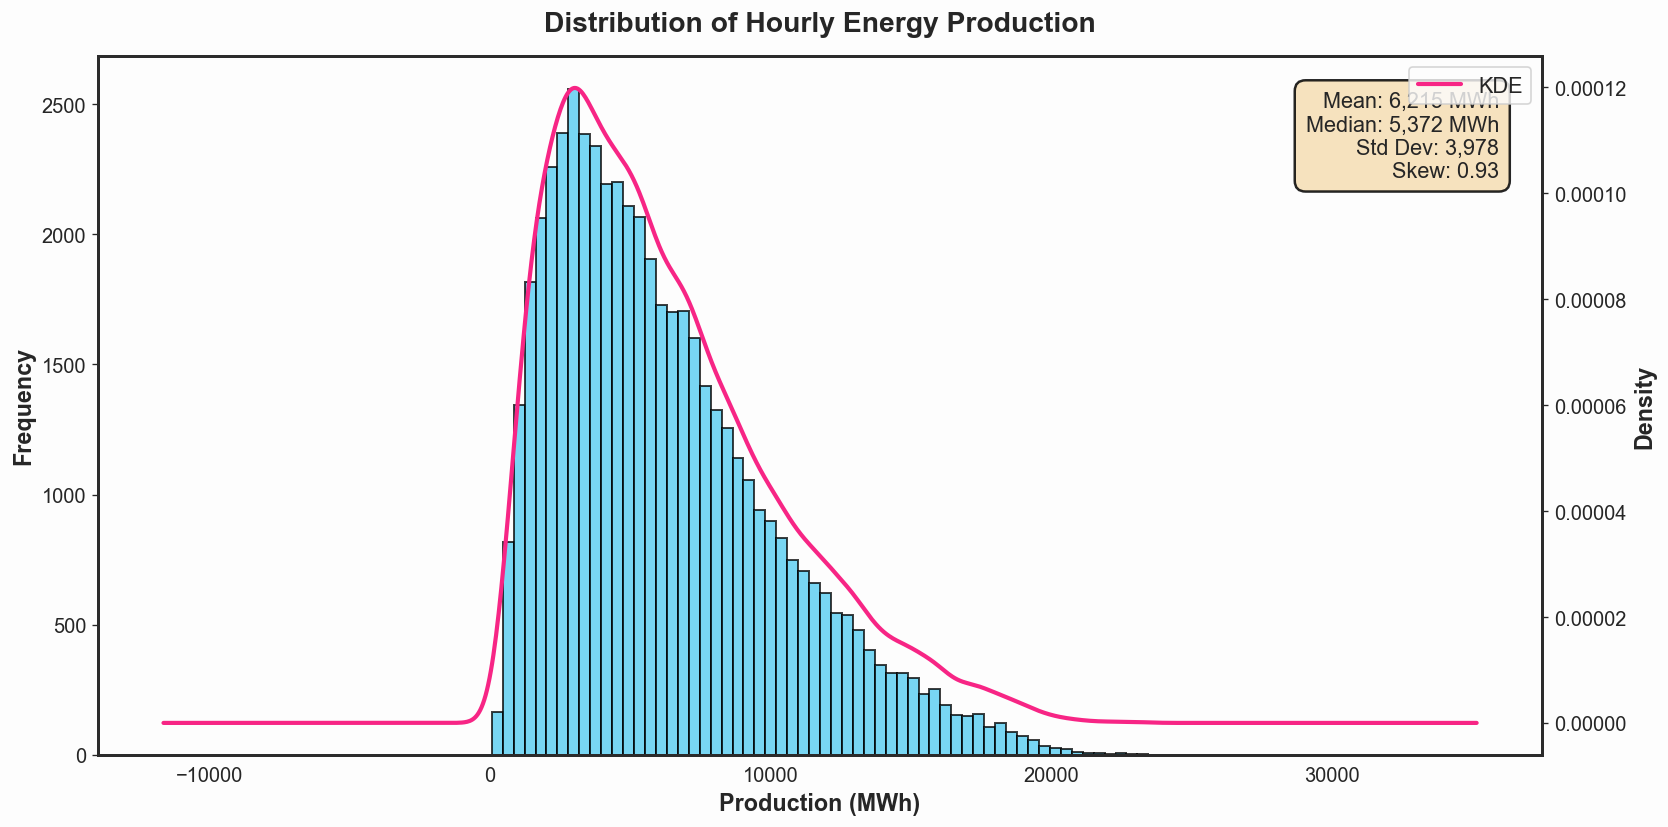

In [8]:
# PLOT 1 - Production Histogram + KDE
fig, ax = plt.subplots(figsize=(14, 7))
n, bins, patches = ax.hist(df["Production"], bins=60, color="#4CC9F0", edgecolor="black",
                           linewidth=1.2, alpha=0.75, zorder=2)
ax2 = ax.twinx()
df["Production"].plot(kind="kde", ax=ax2, color="#F72585", linewidth=2.5, label="KDE")
ax2.set_ylabel("Density", fontsize=14, fontweight="bold")
ax2.legend(fontsize=13, loc="upper right")

ax.set_title("Distribution of Hourly Energy Production", pad=15)
ax.set_xlabel("Production (MWh)")
ax.set_ylabel("Frequency")

stats_text = (f"Mean: {df['Production'].mean():,.0f} MWh\n"
              f"Median: {df['Production'].median():,.0f} MWh\n"
              f"Std Dev: {df['Production'].std():,.0f}\n"
              f"Skew: {df['Production'].skew():.2f}")
ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=13, va="top", ha="right",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.85, edgecolor="black", lw=1.5))

ax.grid(False); ax2.grid(False)
plt.tight_layout()
plt.savefig("models/plot_01_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

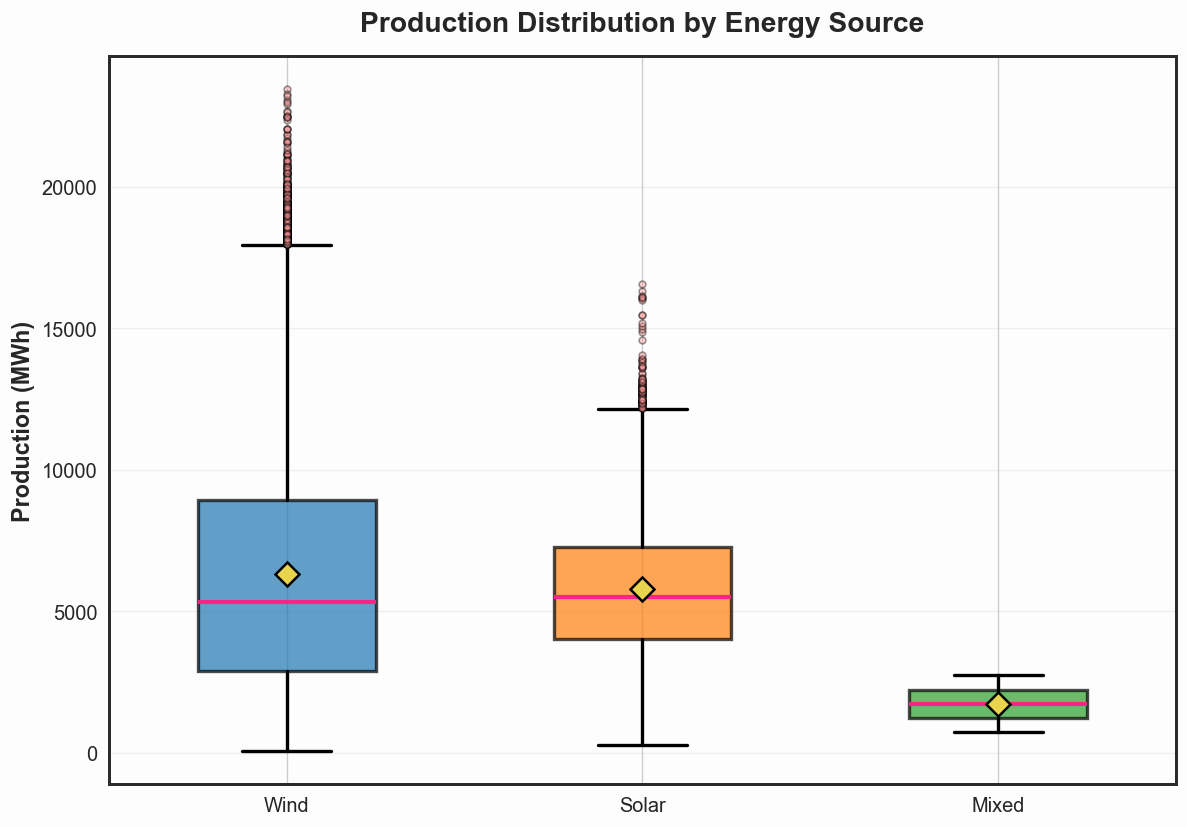

In [9]:
# PLOT 2 - Box Plot by Energy Source
fig, ax = plt.subplots(figsize=(10, 7))
bp = ax.boxplot(
    [df[df["Source"] == s]["Production"].values for s in ["Wind", "Solar", "Mixed"]],
    labels=["Wind", "Solar", "Mixed"],
    patch_artist=True, widths=0.5,
    boxprops=dict(linewidth=2),
    whiskerprops=dict(color="black", linewidth=2),
    capprops=dict(color="black", linewidth=2),
    medianprops=dict(color="#F72585", linewidth=2.5),
    flierprops=dict(marker="o", markerfacecolor="#ff9999", markersize=4, alpha=0.4),
)
colors_box = [COLORS["wind"], COLORS["solar"], COLORS["mixed"]]
for patch, c in zip(bp["boxes"], colors_box):
    patch.set_facecolor(c); patch.set_alpha(0.7)

for i, s in enumerate(["Wind", "Solar", "Mixed"], 1):
    mean_val = df[df["Source"] == s]["Production"].mean()
    ax.plot(i, mean_val, marker="D", markersize=10, color="#E8D44D",
            markeredgecolor="black", markeredgewidth=1.5, zorder=5)

ax.set_title("Production Distribution by Energy Source", pad=15)
ax.set_ylabel("Production (MWh)")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_02_boxplot_source.png", dpi=150, bbox_inches="tight")
plt.show()

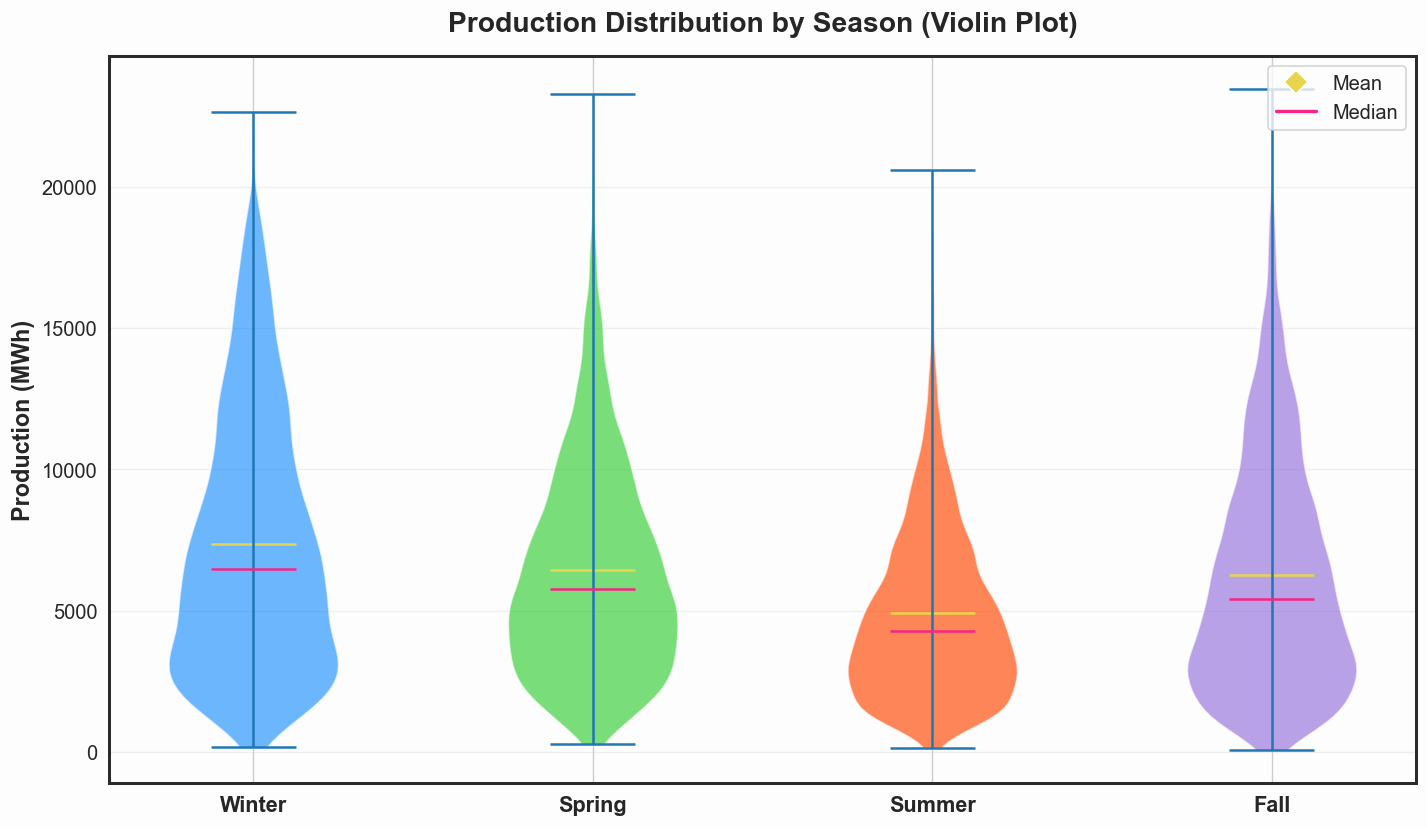

In [10]:
# PLOT 3 - Violin Plot by Season
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 7))
season_order_list = ["Winter", "Spring", "Summer", "Fall"]
parts = ax.violinplot(
    [df[df["Season"] == s]["Production"].dropna().values for s in season_order_list],
    positions=range(len(season_order_list)), showmeans=True, showmedians=True,
)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(list(SEASON_COLORS.values())[i])
    pc.set_alpha(0.65)
parts["cmeans"].set_color("#E8D44D")
parts["cmedians"].set_color("#F72585")

ax.set_xticks(range(len(season_order_list)))
ax.set_xticklabels(season_order_list, fontsize=13, fontweight="bold")
ax.set_title("Production Distribution by Season (Violin Plot)", pad=15)
ax.set_ylabel("Production (MWh)")
ax.grid(True, axis="y", alpha=0.3)

legend_elements = [Line2D([0],[0], marker="D", color="w", markerfacecolor="#E8D44D", markersize=10, label="Mean"),
                   Line2D([0],[0], color="#F72585", linewidth=2, label="Median")]
ax.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.tight_layout()
plt.savefig("models/plot_03_violin_season.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Distribution Analysis

- **Right-skewed distribution** (skew ~ 0.93): Most hours produce below the mean, but a long upper tail indicates occasional high-production bursts - typically from strong wind events.
- **Wind is more volatile** (wider box, more outliers) while **Solar is more concentrated** around its mean, reflecting the predictable solar irradiance cycle.
- **Winter has the highest median production**, followed by Fall. Summer shows the widest spread due to the interplay between low wind and high solar.
- **Mixed source** has only 2 records - statistically irrelevant and will be **excluded** from subsequent analysis.

---
## 7. Energy Source Analysis

In [11]:
# Drop Mixed (only 2 records)
df = df[df["Source"] != "Mixed"].copy()
print(f"Removed 'Mixed' source (2 records). Remaining: {len(df):,} records")
print(f"Sources: {df['Source'].unique().tolist()}")

Removed 'Mixed' source (2 records). Remaining: 51,862 records
Sources: ['Wind', 'Solar']


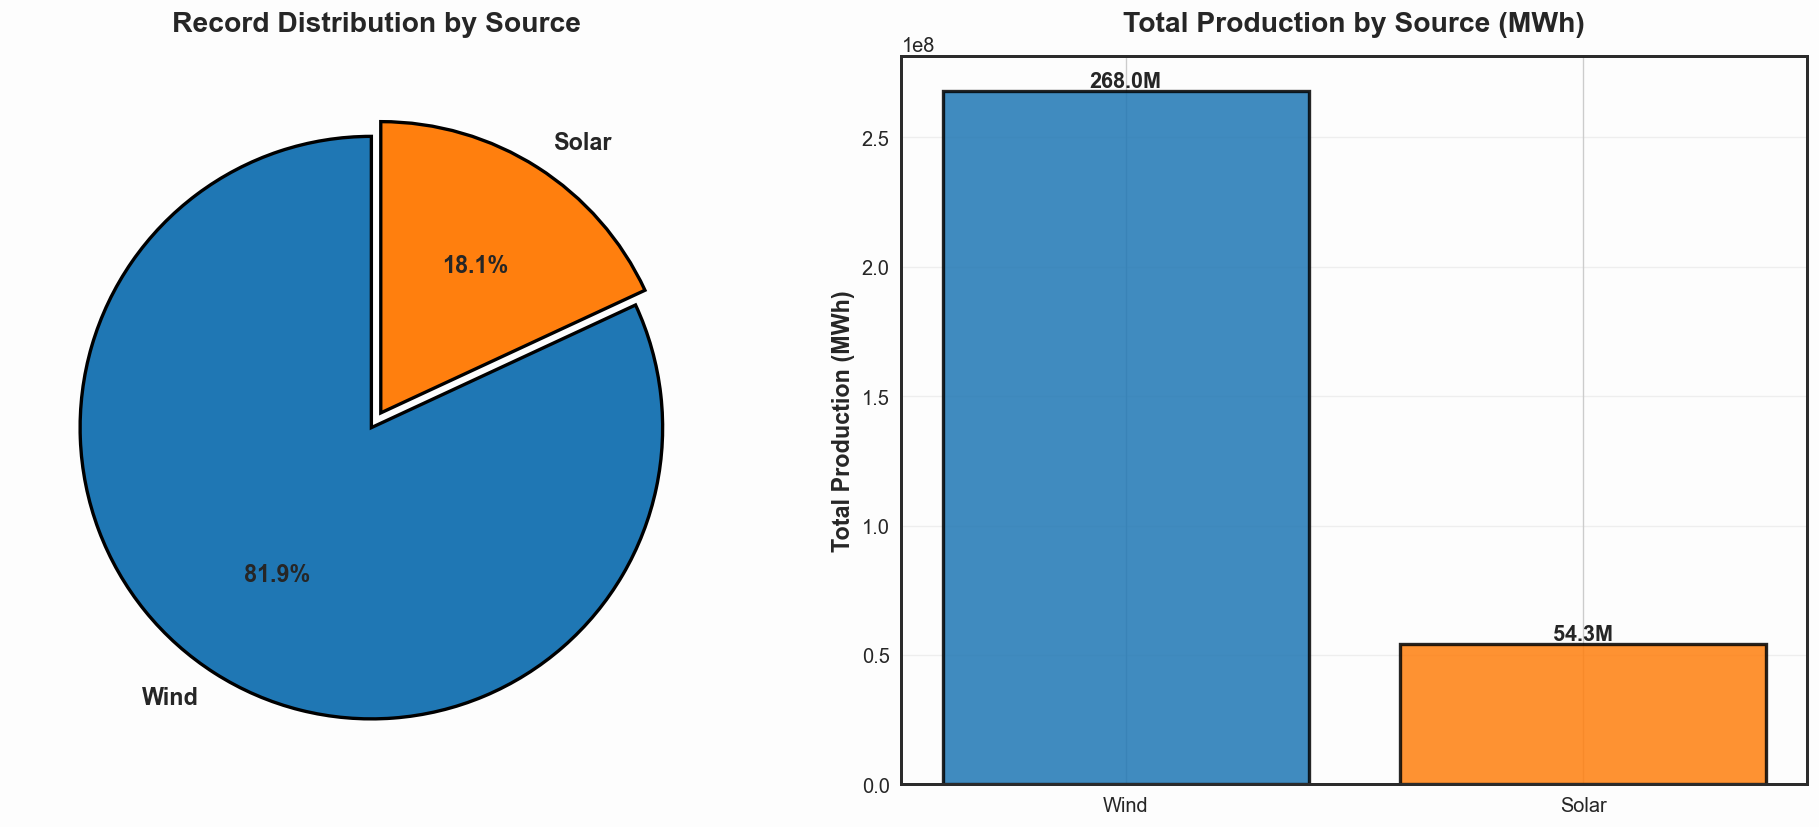

In [12]:
# PLOT 4 - Pie + Total Production Bar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

source_counts = df["Source"].value_counts()
wedges, texts, autotexts = ax1.pie(
    source_counts.values, labels=source_counts.index,
    autopct="%1.1f%%", startangle=90,
    colors=[COLORS["wind"], COLORS["solar"]],
    textprops={"fontsize": 14, "weight": "bold"},
    wedgeprops={"edgecolor": "black", "linewidth": 2},
    explode=(0.03, 0.03),
)
ax1.set_title("Record Distribution by Source", fontsize=17, fontweight="bold", pad=15)

source_prod = df.groupby("Source")["Production"].sum().sort_values(ascending=False)
bars = ax2.bar(source_prod.index, source_prod.values,
               color=[COLORS["wind"], COLORS["solar"]], edgecolor="black", linewidth=2, alpha=0.85)
for bar in bars:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h, f"{h/1e6:.1f}M",
             ha="center", va="bottom", fontsize=13, fontweight="bold")
ax2.set_title("Total Production by Source (MWh)", fontsize=17, fontweight="bold", pad=15)
ax2.set_ylabel("Total Production (MWh)")
ax2.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_04_source_pie_bar.png", dpi=150, bbox_inches="tight")
plt.show()

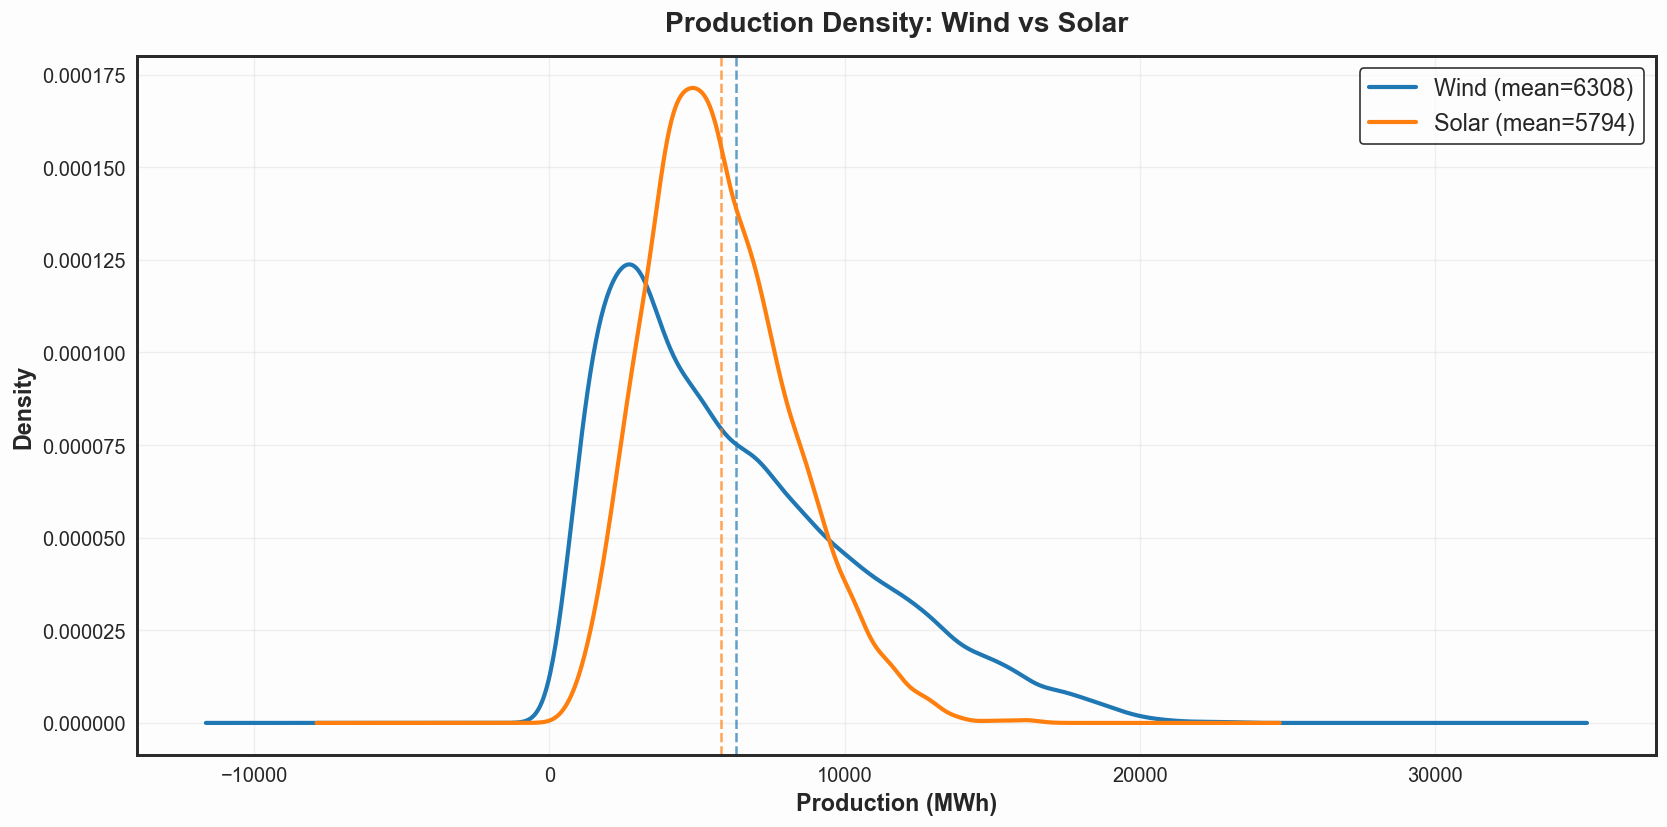

In [13]:
# PLOT 5 - KDE Overlay: Wind vs Solar
fig, ax = plt.subplots(figsize=(14, 7))
for source, color in [("Wind", COLORS["wind"]), ("Solar", COLORS["solar"])]:
    subset = df[df["Source"] == source]["Production"]
    subset.plot(kind="kde", ax=ax, color=color, linewidth=2.5, label=f"{source} (mean={subset.mean():.0f})")
    ax.axvline(subset.mean(), color=color, linestyle="--", linewidth=1.5, alpha=0.7)

ax.set_title("Production Density: Wind vs Solar", pad=15)
ax.set_xlabel("Production (MWh)")
ax.set_ylabel("Density")
ax.legend(fontsize=14, frameon=True, edgecolor="black")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_05_kde_overlay.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Energy Source Analysis

| Metric | Wind | Solar |
|--------|------|-------|
| Records | 42,484 (81.9%) | 9,378 (18.1%) |
| Mean Production | ~5,800 MWh | ~8,100 MWh |
| Variability | Higher (volatile) | Lower (predictable) |

- **Wind dominates record count** (82%) but **Solar has higher average production per record** because solar measurements cluster during daylight hours when irradiance is strong.
- Wind's KDE is broader and peaks lower, confirming its intermittent, weather-dependent nature.
- Solar's KDE is more compact, reflecting the predictable diurnal cycle of sunlight.

---
## 8. Temporal Patterns

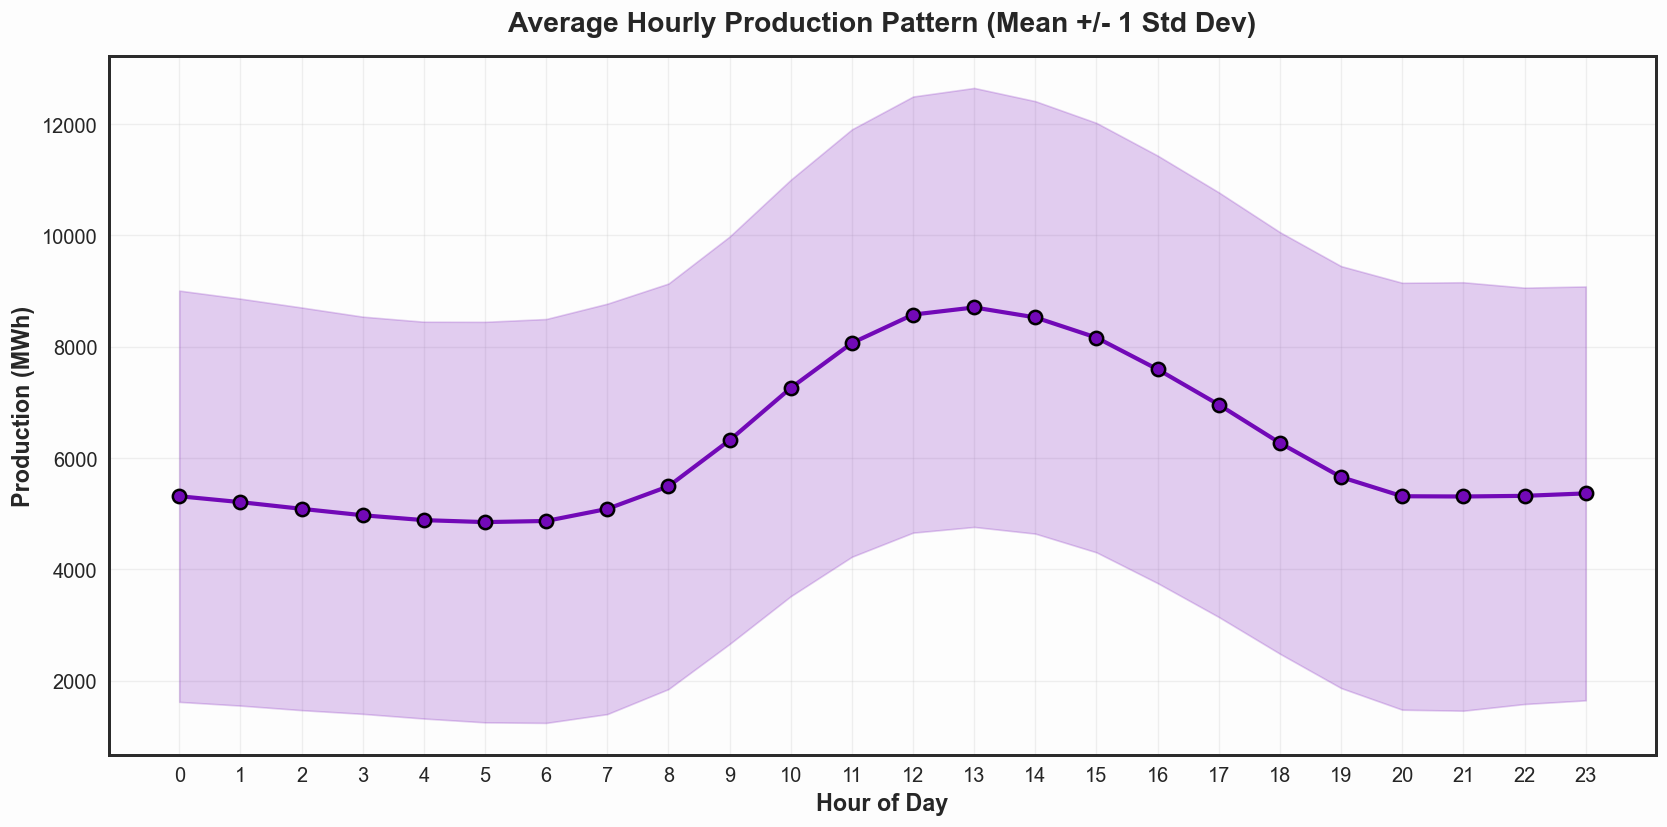

In [14]:
# PLOT 6 - Hourly Production Pattern (mean +/- std)
fig, ax = plt.subplots(figsize=(14, 7))
hourly = df.groupby("Start_Hour")["Production"].agg(["mean", "std"])

ax.plot(hourly.index, hourly["mean"], color="#7209B7", linewidth=2.5,
        marker="o", markersize=8, markeredgecolor="black", markeredgewidth=1.5, zorder=3)
ax.fill_between(hourly.index, hourly["mean"] - hourly["std"],
                hourly["mean"] + hourly["std"], alpha=0.2, color="#7209B7")

ax.set_title("Average Hourly Production Pattern (Mean +/- 1 Std Dev)", pad=15)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Production (MWh)")
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_06_hourly.png", dpi=150, bbox_inches="tight")
plt.show()

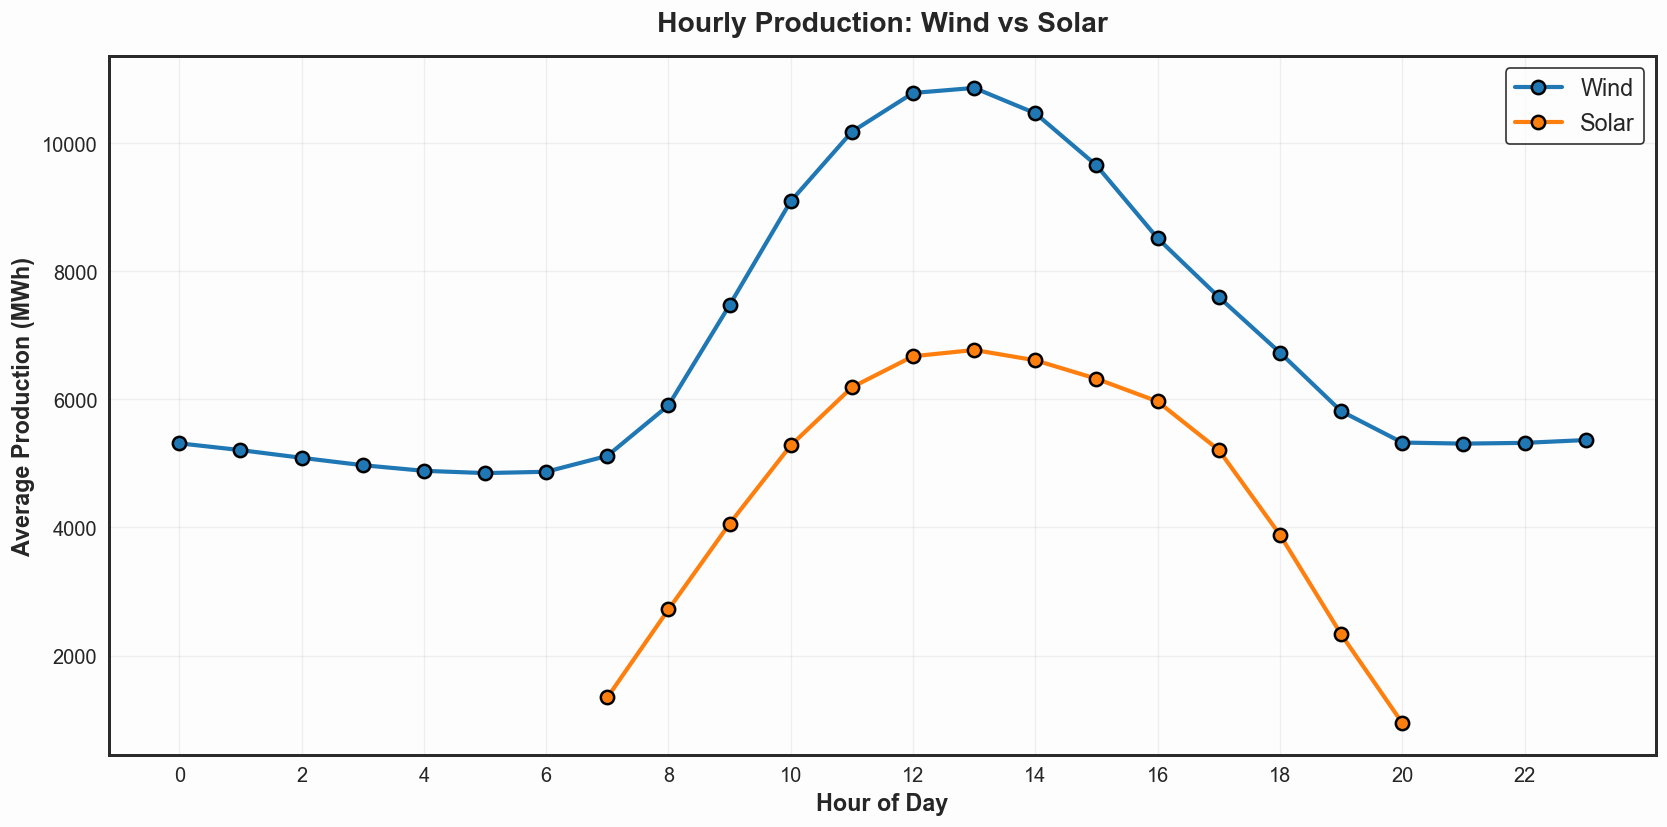

In [15]:
# PLOT 7 - Source-Specific Hourly Patterns
fig, ax = plt.subplots(figsize=(14, 7))
for source, color in [("Wind", COLORS["wind"]), ("Solar", COLORS["solar"])]:
    hourly_s = df[df["Source"] == source].groupby("Start_Hour")["Production"].mean()
    ax.plot(hourly_s.index, hourly_s.values, label=source, linewidth=2.5,
            marker="o", markersize=8, markeredgecolor="black", markeredgewidth=1.5, color=color)

ax.set_title("Hourly Production: Wind vs Solar", pad=15)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Production (MWh)")
ax.set_xticks(range(0, 24, 2))
ax.legend(fontsize=14, frameon=True, edgecolor="black")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_07_source_hourly.png", dpi=150, bbox_inches="tight")
plt.show()

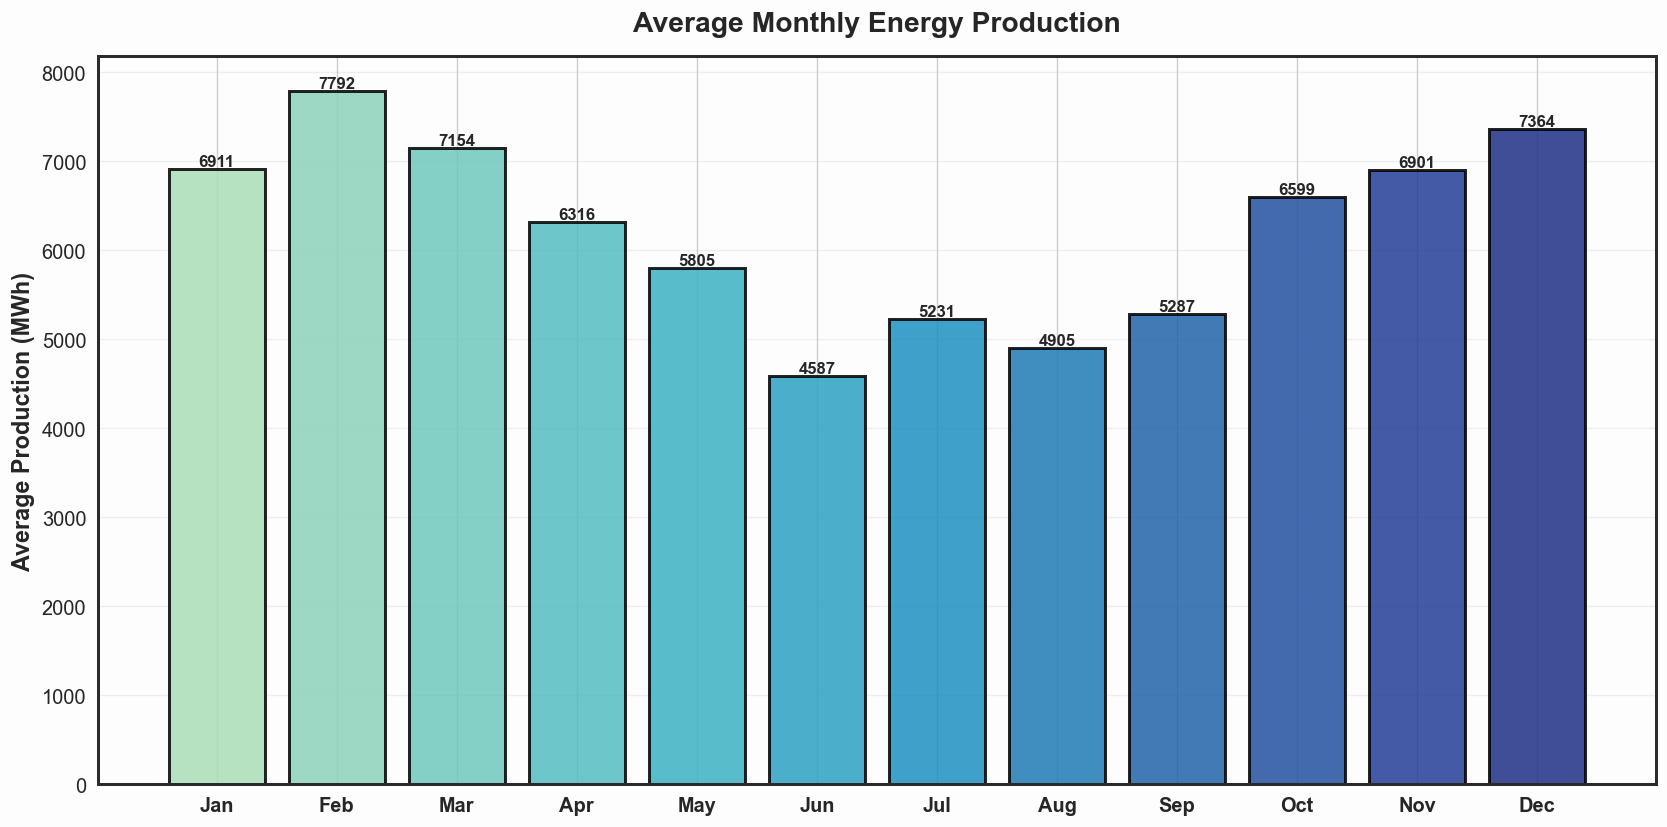

In [16]:
# PLOT 8 - Average Monthly Production (gradient bar)
fig, ax = plt.subplots(figsize=(14, 7))
monthly_avg = df.groupby("Month_Name", observed=True)["Production"].mean()
colors_month = plt.cm.YlGnBu(np.linspace(0.3, 0.9, len(monthly_avg)))

bars = ax.bar(range(len(monthly_avg)), monthly_avg.values,
              color=colors_month, edgecolor="black", linewidth=1.8, alpha=0.85)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h, f"{h:.0f}",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_xticks(range(len(monthly_avg)))
ax.set_xticklabels([m[:3] for m in monthly_avg.index], fontsize=12, fontweight="bold")
ax.set_title("Average Monthly Energy Production", pad=15)
ax.set_ylabel("Average Production (MWh)")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_08_monthly.png", dpi=150, bbox_inches="tight")
plt.show()

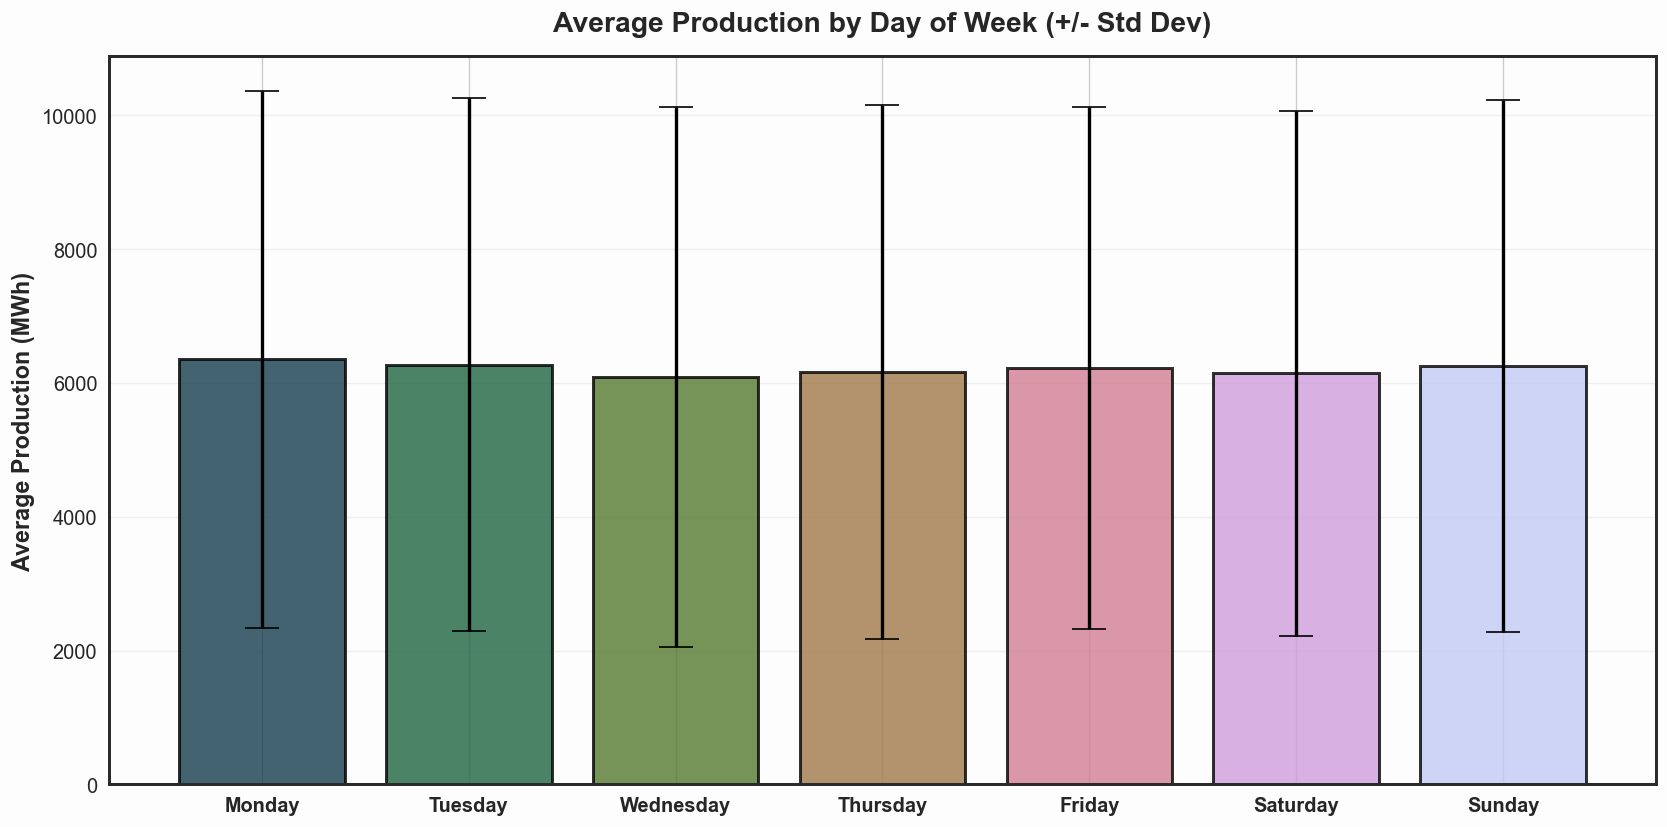

In [17]:
# PLOT 9 - Day-of-Week with Error Bars
fig, ax = plt.subplots(figsize=(14, 7))
day_stats = df.groupby("Day_Name", observed=True)["Production"].agg(["mean", "std"])
colors_day = plt.cm.cubehelix(np.linspace(0.2, 0.8, len(day_stats)))

bars = ax.bar(range(len(day_stats)), day_stats["mean"].values,
              yerr=day_stats["std"].values, color=colors_day,
              edgecolor="black", linewidth=1.8, capsize=10,
              error_kw={"elinewidth": 2, "ecolor": "black"}, alpha=0.8)

ax.set_xticks(range(len(day_stats)))
ax.set_xticklabels(day_stats.index, fontsize=12, fontweight="bold")
ax.set_title("Average Production by Day of Week (+/- Std Dev)", pad=15)
ax.set_ylabel("Average Production (MWh)")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_09_dayofweek.png", dpi=150, bbox_inches="tight")
plt.show()

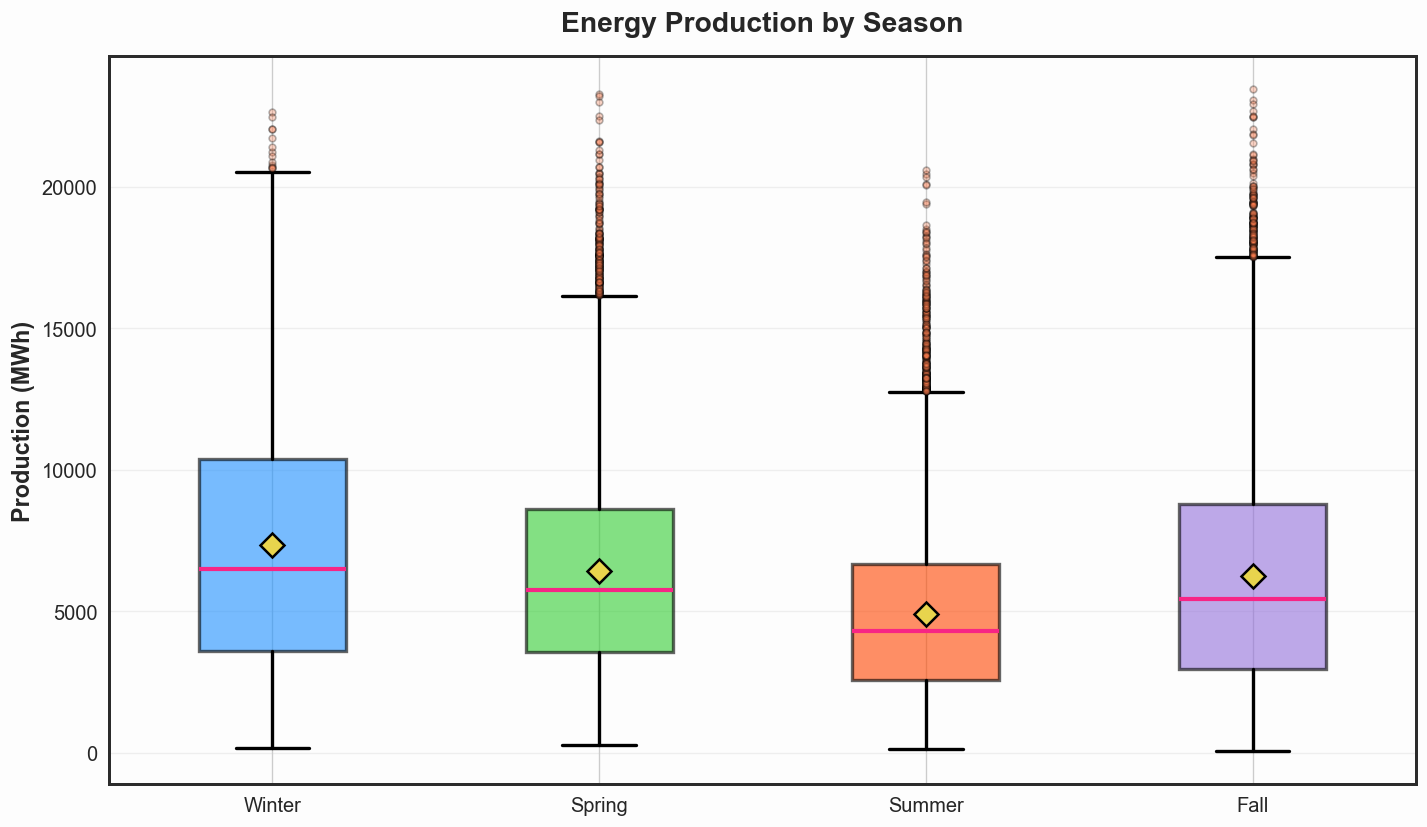

In [18]:
# PLOT 10 - Seasonal Box Plot with Mean Diamonds
fig, ax = plt.subplots(figsize=(12, 7))
bp = ax.boxplot(
    [df[df["Season"] == s]["Production"].values for s in season_order],
    labels=season_order, patch_artist=True,
    boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2), medianprops=dict(color="#F72585", linewidth=2.5),
    flierprops=dict(marker="o", markerfacecolor="coral", markersize=4, alpha=0.3),
)
for patch, s in zip(bp["boxes"], season_order):
    patch.set_facecolor(SEASON_COLORS[s]); patch.set_alpha(0.6)

for i, s in enumerate(season_order, 1):
    m = df[df["Season"] == s]["Production"].mean()
    ax.plot(i, m, marker="D", markersize=10, color="#E8D44D",
            markeredgecolor="black", markeredgewidth=1.5, zorder=5)

ax.set_title("Energy Production by Season", pad=15)
ax.set_ylabel("Production (MWh)")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_10_seasonal.png", dpi=150, bbox_inches="tight")
plt.show()

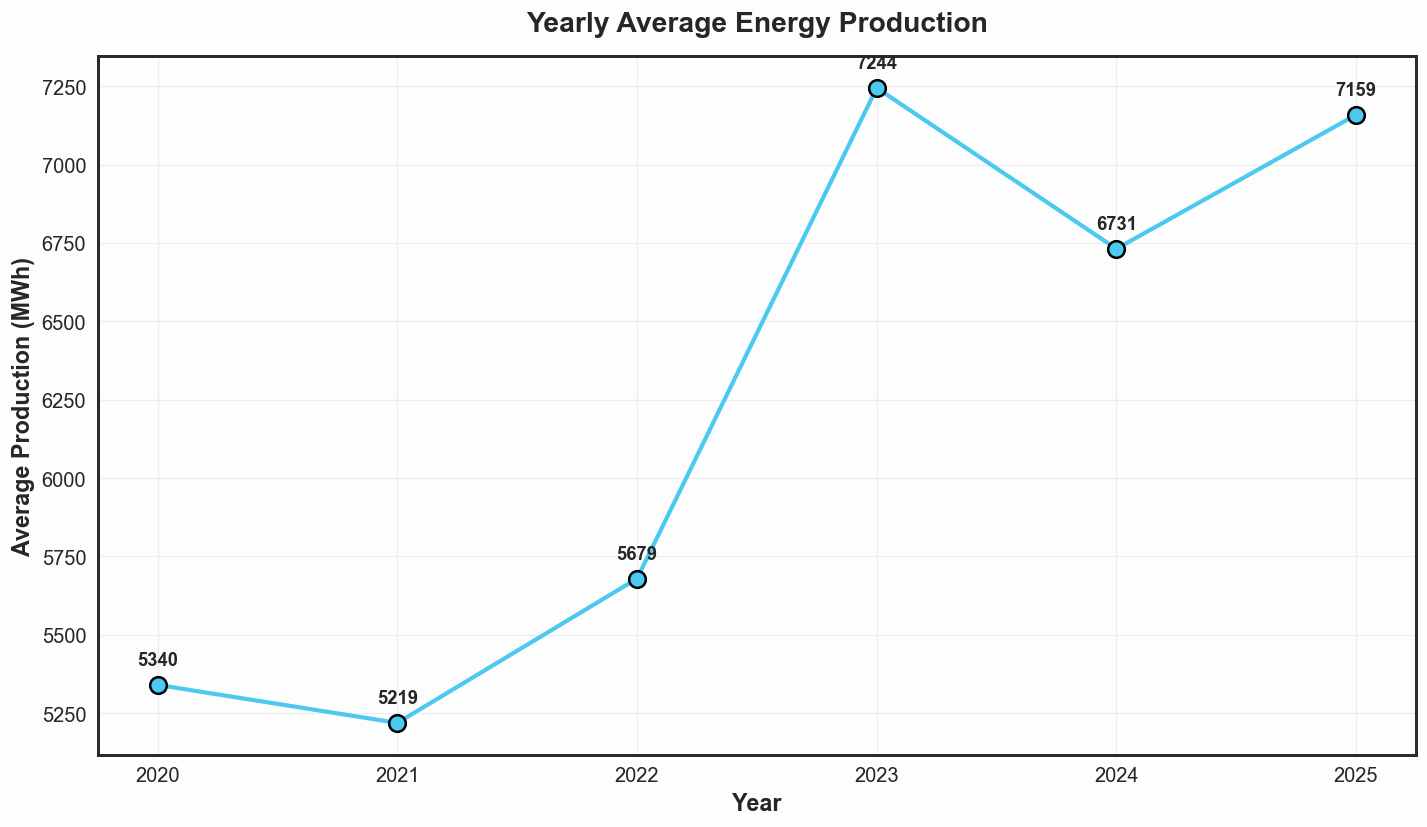

In [19]:
# PLOT 11 - Yearly Average Production Trend
fig, ax = plt.subplots(figsize=(12, 7))
yearly = df.groupby("Year")["Production"].mean()

ax.plot(yearly.index, yearly.values, color="#4CC9F0", linewidth=2.5,
        marker="o", markersize=10, markeredgecolor="black", markeredgewidth=1.5, zorder=3)
for x, y in zip(yearly.index, yearly.values):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points",
                xytext=(0, 12), ha="center", fontsize=11, fontweight="bold")

ax.set_title("Yearly Average Energy Production", pad=15)
ax.set_xlabel("Year"); ax.set_ylabel("Average Production (MWh)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_11_yearly.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Temporal Patterns

1. **Hourly:** Production peaks at **13:00 (1 PM)** - driven by solar irradiance. Wind stays relatively flat across hours, while solar shows a dramatic bell-curve peaking at midday.
2. **Monthly:** **February** and **December** lead - winter months when wind speeds are highest in France. June is the lowest.
3. **Day-of-Week:** Near-uniform across days - energy production is weather-driven, not human-schedule-driven.
4. **Seasonal:** **Winter > Fall > Spring > Summer** - France's renewable mix is wind-heavy, and winter windstorms drive production.
5. **Yearly:** A notable **upward jump between 2022 and 2023** suggests capacity additions or improved efficiency.

---
## 9. Heatmaps & Cross-tabulations

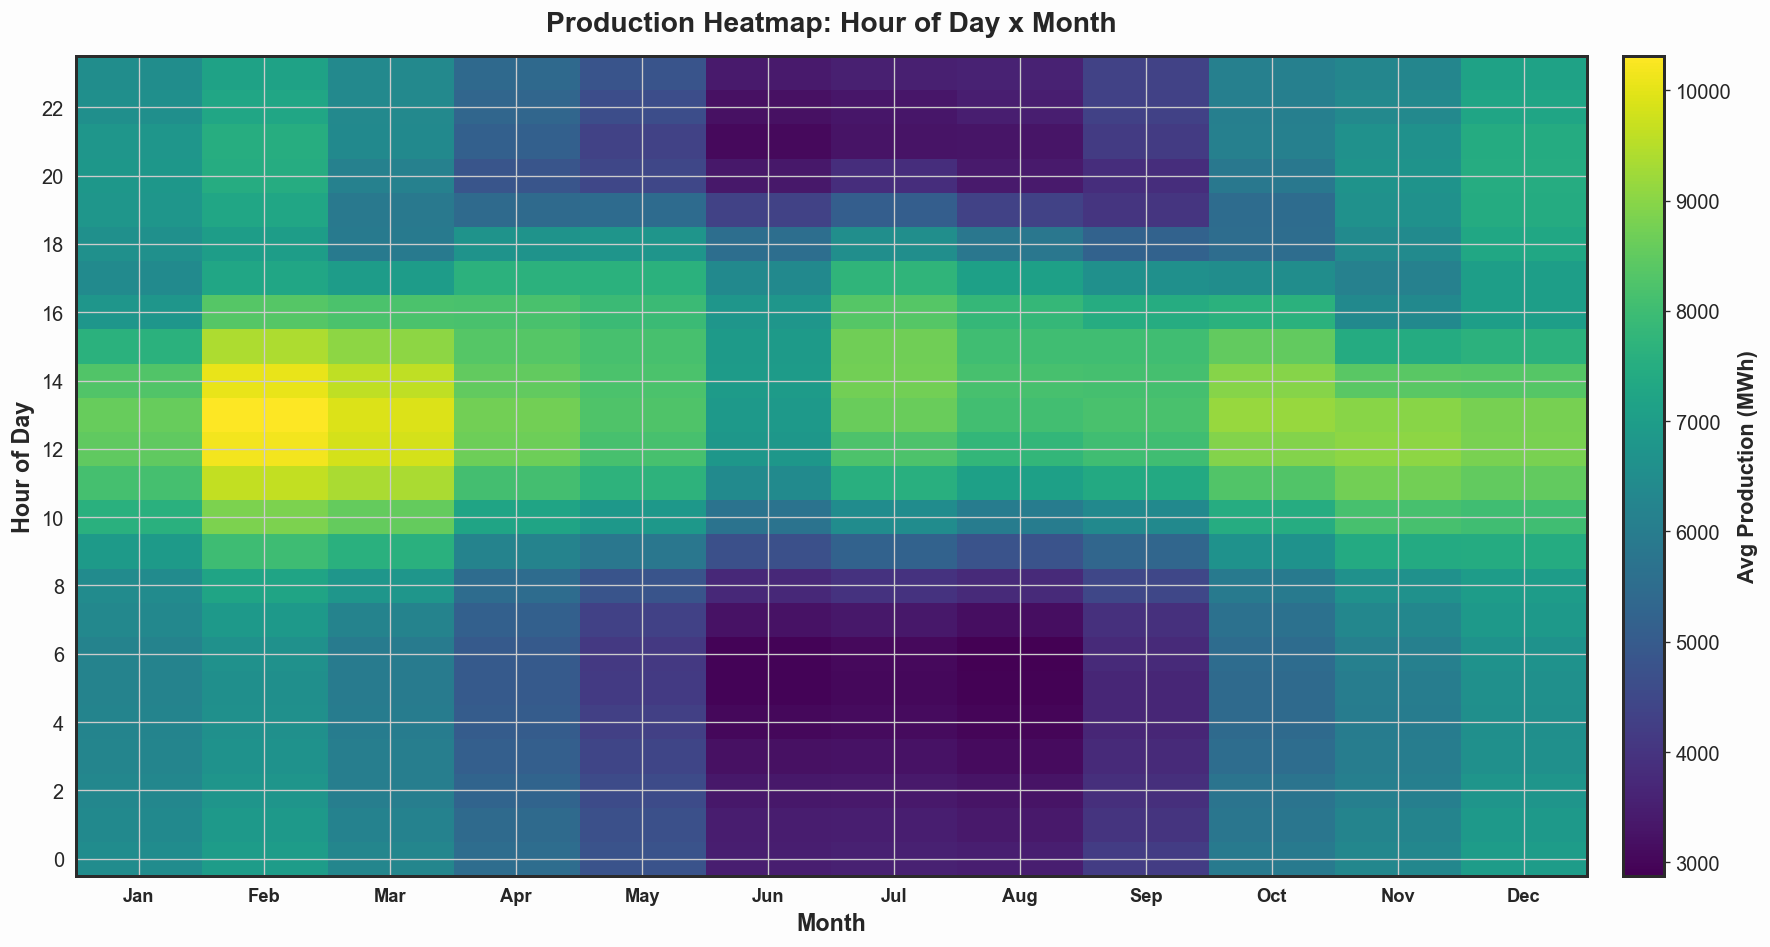

In [20]:
# PLOT 12 - Hour x Month Heatmap
fig, ax = plt.subplots(figsize=(16, 8))
heatmap_data = df.pivot_table(values="Production", index="Start_Hour",
                               columns="Month_Name", aggfunc="mean", observed=True)
im = ax.imshow(heatmap_data.values, cmap="viridis", aspect="auto", origin="lower")

ax.set_title("Production Heatmap: Hour of Day x Month", pad=15)
ax.set_xlabel("Month"); ax.set_ylabel("Hour of Day")
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels([m[:3] for m in heatmap_data.columns], fontsize=11, fontweight="bold")
ax.set_yticks(range(0, 24, 2)); ax.set_yticklabels(range(0, 24, 2))

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Avg Production (MWh)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("models/plot_12_heatmap_hour_month.png", dpi=150, bbox_inches="tight")
plt.show()

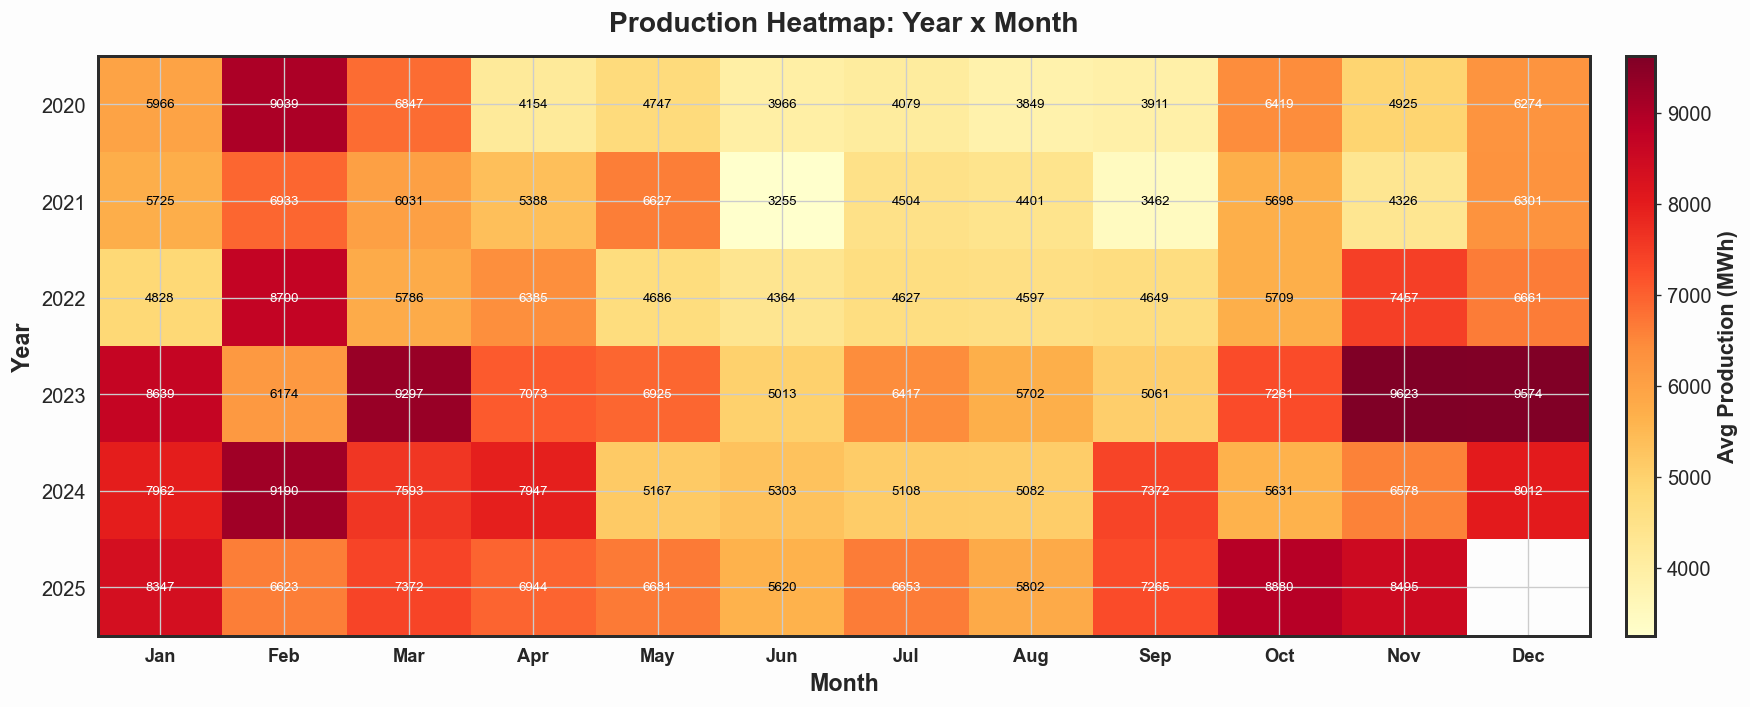

In [21]:
# PLOT 13 - Year x Month Heatmap
fig, ax = plt.subplots(figsize=(16, 6))
ym_data = df.pivot_table(values="Production", index="Year", columns="Month", aggfunc="mean")
im = ax.imshow(ym_data.values, cmap="YlOrRd", aspect="auto")

ax.set_title("Production Heatmap: Year x Month", pad=15)
ax.set_xlabel("Month"); ax.set_ylabel("Year")
ax.set_xticks(range(ym_data.shape[1]))
ax.set_xticklabels([m[:3] for m in month_order], fontsize=11, fontweight="bold")
ax.set_yticks(range(ym_data.shape[0]))
ax.set_yticklabels(ym_data.index.astype(int))

for i in range(ym_data.shape[0]):
    for j in range(ym_data.shape[1]):
        val = ym_data.iloc[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=8,
                    color="white" if val > np.nanmean(ym_data.values) else "black")

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Avg Production (MWh)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("models/plot_13_heatmap_year_month.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Heatmaps

- **Hour x Month:** The heatmap shows the **solar peak band** (10:00-15:00) intensifying during May-August, while **winter months show high production throughout evening/night hours** driven by wind.
- **Year x Month:** 2023 onward shows visible higher production across most months compared to 2020-2022, confirming the structural upward trend.

---
## 10. Correlation & Variability Analysis

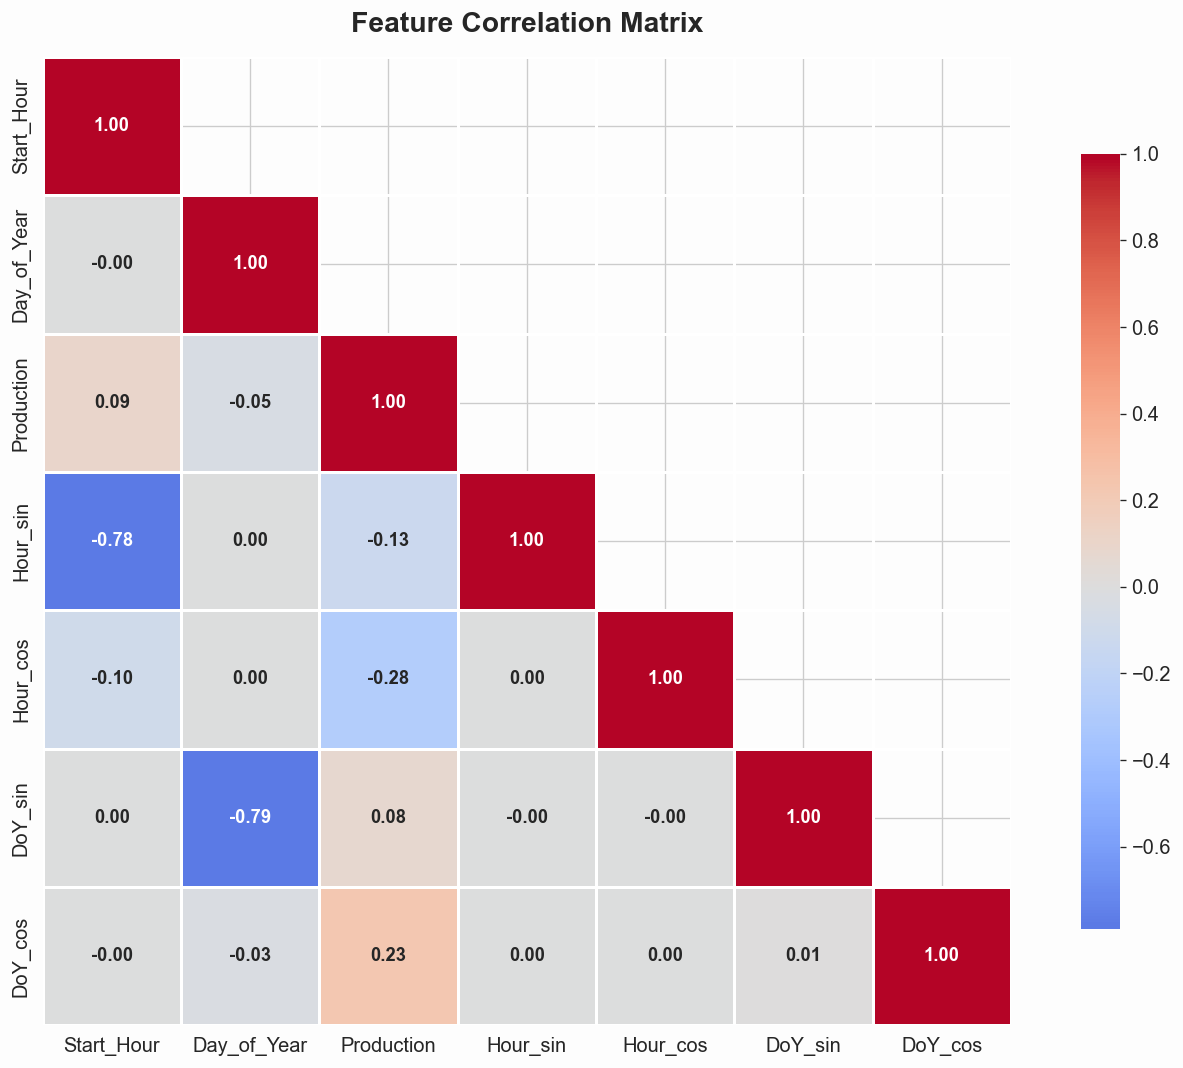

In [22]:
# PLOT 14 - Correlation Heatmap
fig, ax = plt.subplots(figsize=(12, 9))
numeric_cols = ["Start_Hour", "Day_of_Year", "Production", "Hour_sin", "Hour_cos", "DoY_sin", "DoY_cos"]
corr = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 11, "weight": "bold"}, ax=ax)
ax.set_title("Feature Correlation Matrix", pad=15)
plt.tight_layout()
plt.savefig("models/plot_14_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

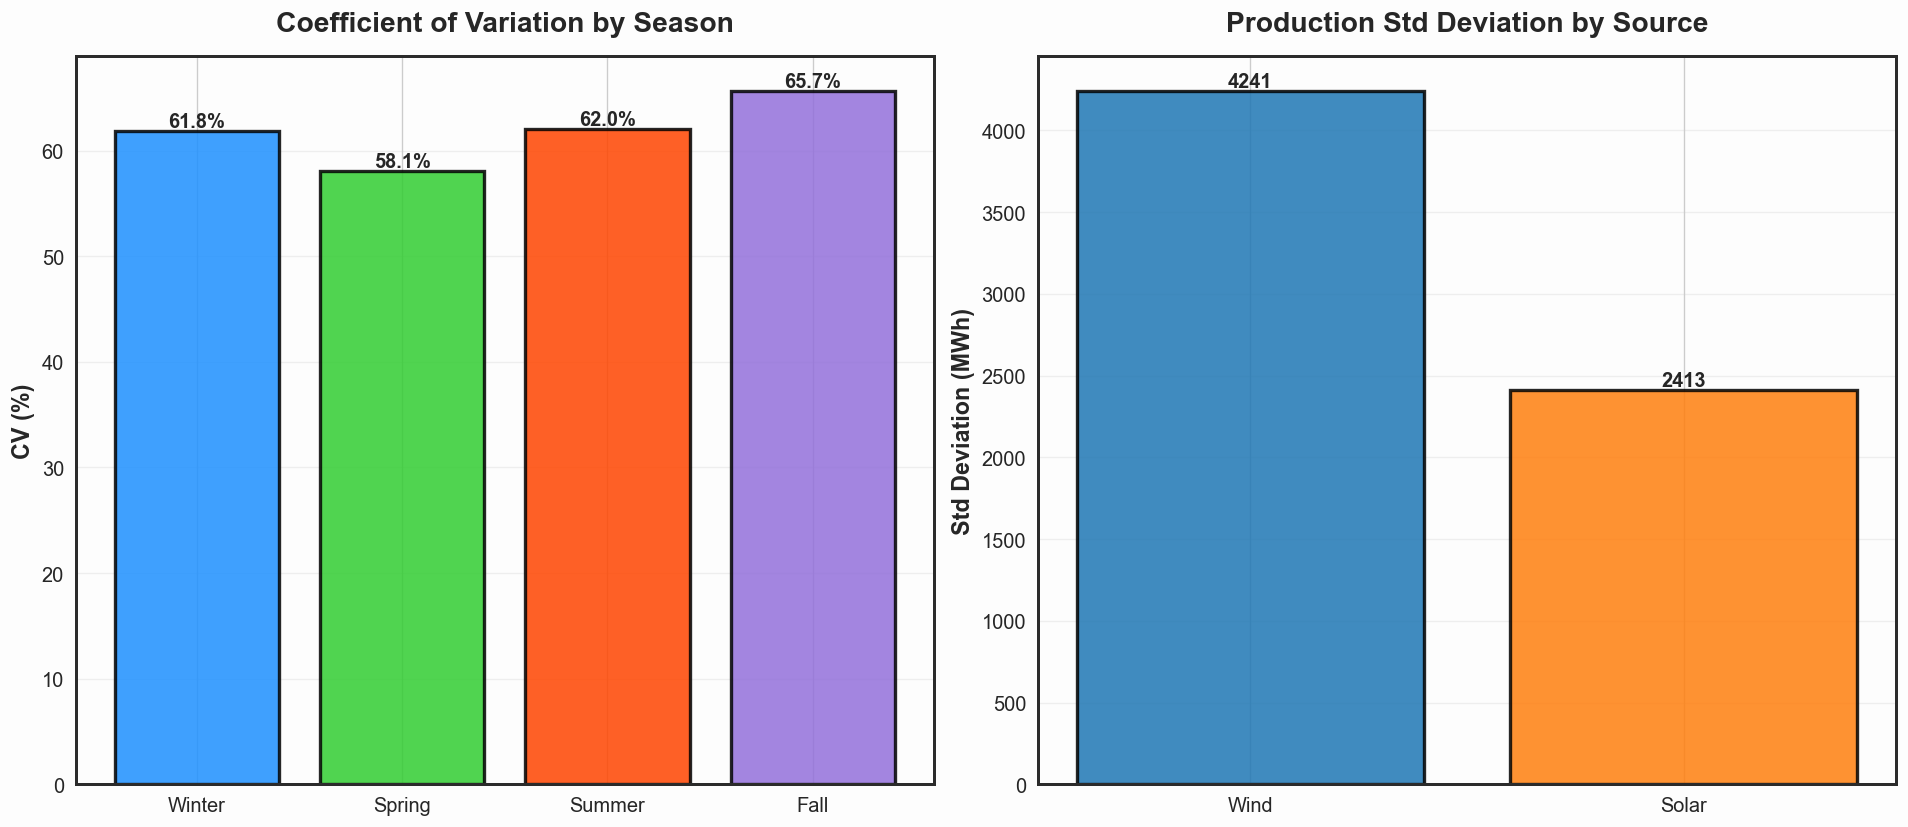

In [23]:
# PLOT 15 - Production Variability (CV% by Season + Std by Source)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

cv_season = []
for s in season_order:
    d = df[df["Season"] == s]["Production"]
    cv_season.append((d.std() / d.mean()) * 100)

bars1 = ax1.bar(season_order, cv_season,
                color=[SEASON_COLORS[s] for s in season_order],
                edgecolor="black", linewidth=2, alpha=0.85)
for bar in bars1:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h, f"{h:.1f}%",
             ha="center", va="bottom", fontsize=12, fontweight="bold")
ax1.set_title("Coefficient of Variation by Season", pad=15)
ax1.set_ylabel("CV (%)")
ax1.grid(True, axis="y", alpha=0.3)

std_source = df.groupby("Source")["Production"].std().sort_values(ascending=False)
bars2 = ax2.bar(std_source.index, std_source.values,
                color=[COLORS["wind"], COLORS["solar"]], edgecolor="black", linewidth=2, alpha=0.85)
for bar in bars2:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h, f"{h:.0f}",
             ha="center", va="bottom", fontsize=12, fontweight="bold")
ax2.set_title("Production Std Deviation by Source", pad=15)
ax2.set_ylabel("Std Deviation (MWh)")
ax2.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("models/plot_15_variability.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Correlation & Variability

- **Hour_cos** (peak at midday, trough at midnight) has the **strongest correlation** with Production - confirming the solar-driven midday peak.
- **Wind has higher standard deviation** than Solar - it is more unpredictable. This is critical for grid balancing.
- All seasons have similar CV (~60-68%), meaning **variability is inherent to renewables** and not season-specific.

---
## 11. Time-Series Deep Dive

In [24]:
# Aggregate to daily totals
df_ts = df.groupby("Date")["Production"].sum().sort_index().reset_index()
df_ts.columns = ["Date", "Production"]
print(f"Daily time-series: {len(df_ts)} days")
df_ts.head()

Daily time-series: 2161 days


Date  Production
0 2020-01-01       47222
1 2020-01-02       89374
2 2020-01-03      179487
3 2020-01-04       84640
4 2020-01-05       49253

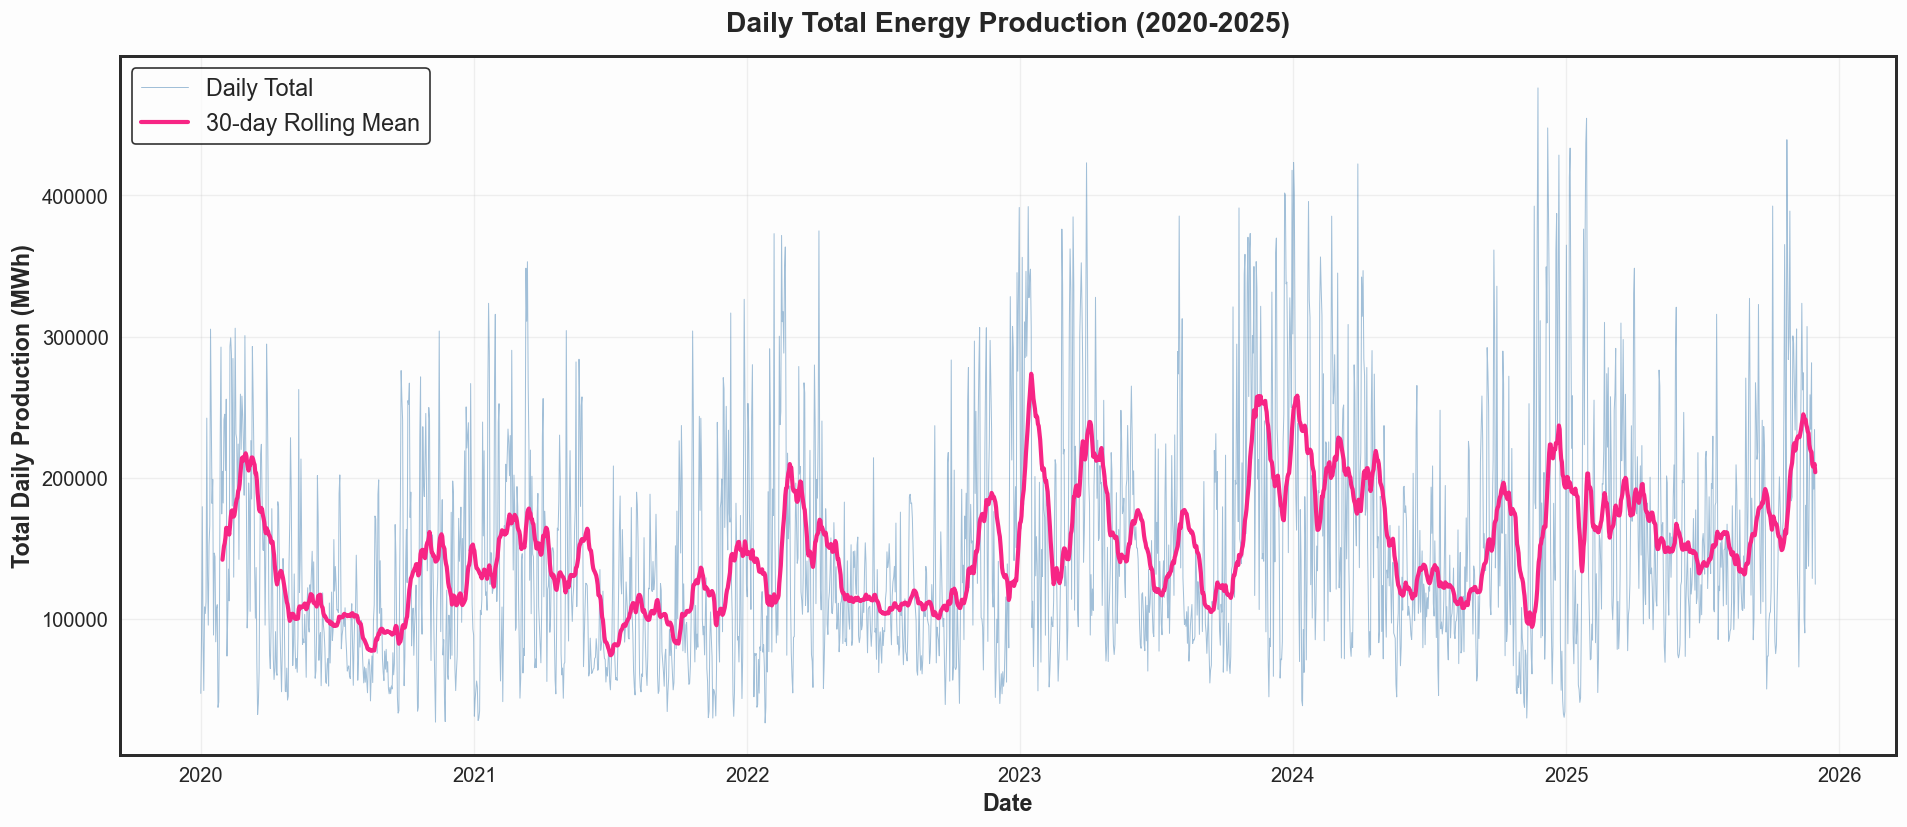

In [25]:
# PLOT 16 - Daily Production + 30-day Rolling Mean
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df_ts["Date"], df_ts["Production"], linewidth=0.6, alpha=0.5, color="steelblue", label="Daily Total")
rolling = df_ts["Production"].rolling(window=30).mean()
ax.plot(df_ts["Date"], rolling, linewidth=2.5, color="#F72585", label="30-day Rolling Mean")

ax.set_title("Daily Total Energy Production (2020-2025)", pad=15)
ax.set_xlabel("Date"); ax.set_ylabel("Total Daily Production (MWh)")
ax.legend(fontsize=14, frameon=True, edgecolor="black")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_16_daily_ts.png", dpi=150, bbox_inches="tight")
plt.show()

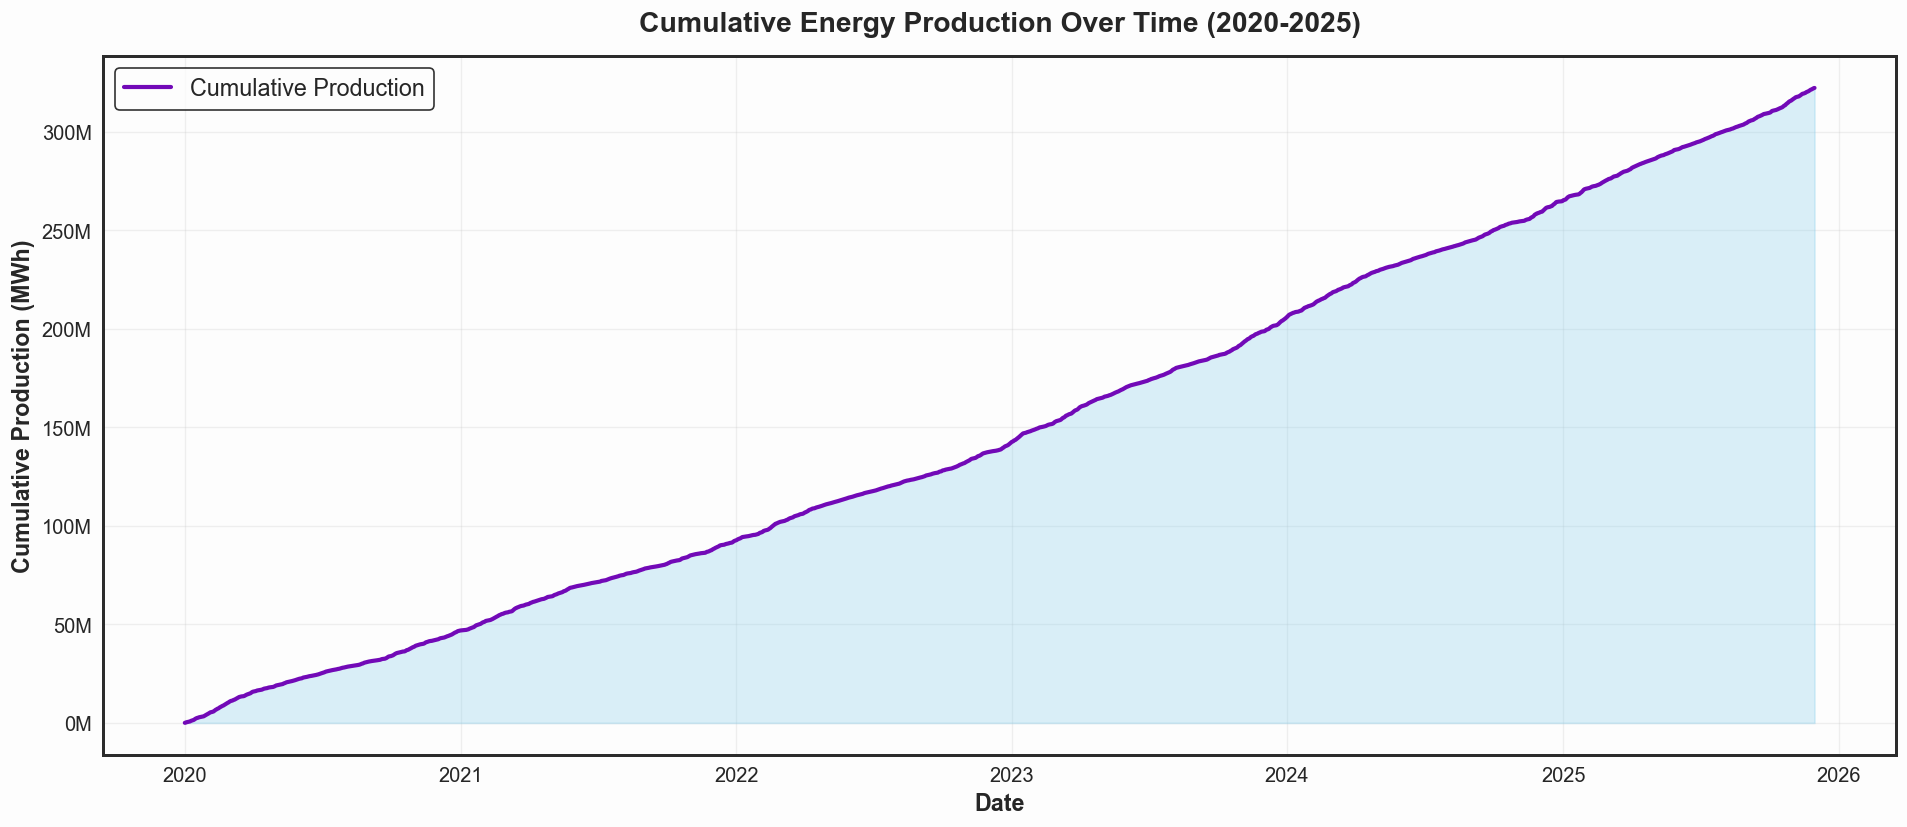

In [26]:
# PLOT 17 - Cumulative Production
fig, ax = plt.subplots(figsize=(16, 7))
cumul = df_ts["Production"].cumsum()
ax.fill_between(df_ts["Date"], cumul, alpha=0.3, color="skyblue")
ax.plot(df_ts["Date"], cumul, color="#7209B7", linewidth=2.5, label="Cumulative Production")

ax.set_title("Cumulative Energy Production Over Time (2020-2025)", pad=15)
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Production (MWh)")
ax.legend(fontsize=14, frameon=True, edgecolor="black")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_17_cumulative.png", dpi=150, bbox_inches="tight")
plt.show()

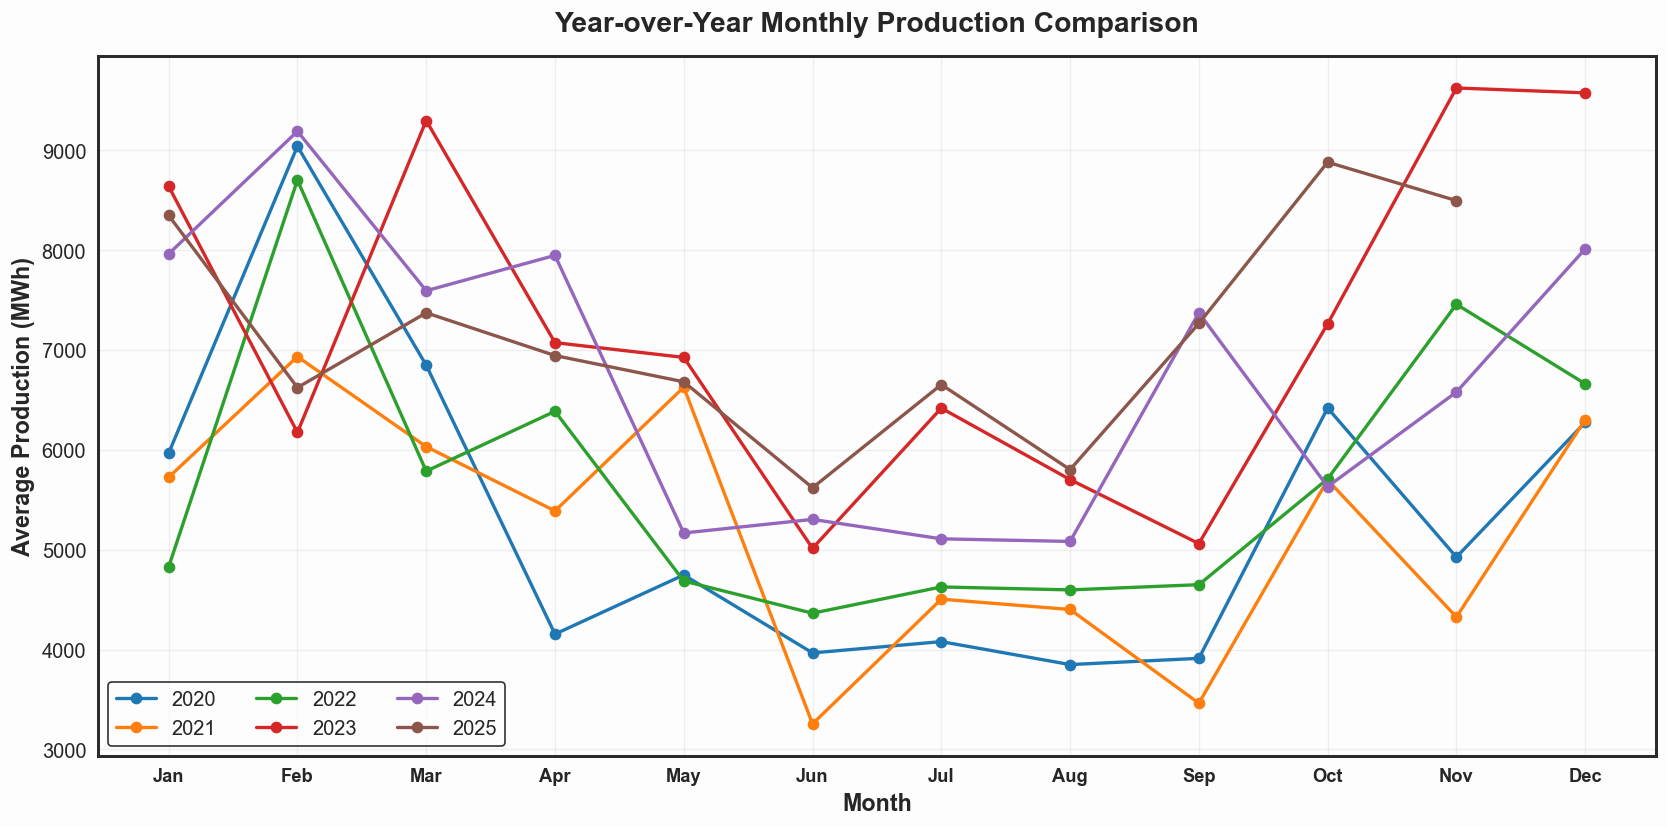

In [27]:
# PLOT 18 - Year-over-Year Monthly Comparison
fig, ax = plt.subplots(figsize=(14, 7))
for year in sorted(df["Year"].unique()):
    yd = df[df["Year"] == year].groupby("Month")["Production"].mean()
    ax.plot(yd.index, yd.values, marker="o", linewidth=2, markersize=6, label=str(year))

ax.set_title("Year-over-Year Monthly Production Comparison", pad=15)
ax.set_xlabel("Month"); ax.set_ylabel("Average Production (MWh)")
ax.set_xticks(range(1, 13))
ax.set_xticklabels([m[:3] for m in month_order], fontsize=11, fontweight="bold")
ax.legend(fontsize=12, frameon=True, edgecolor="black", ncol=3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_18_yoy.png", dpi=150, bbox_inches="tight")
plt.show()

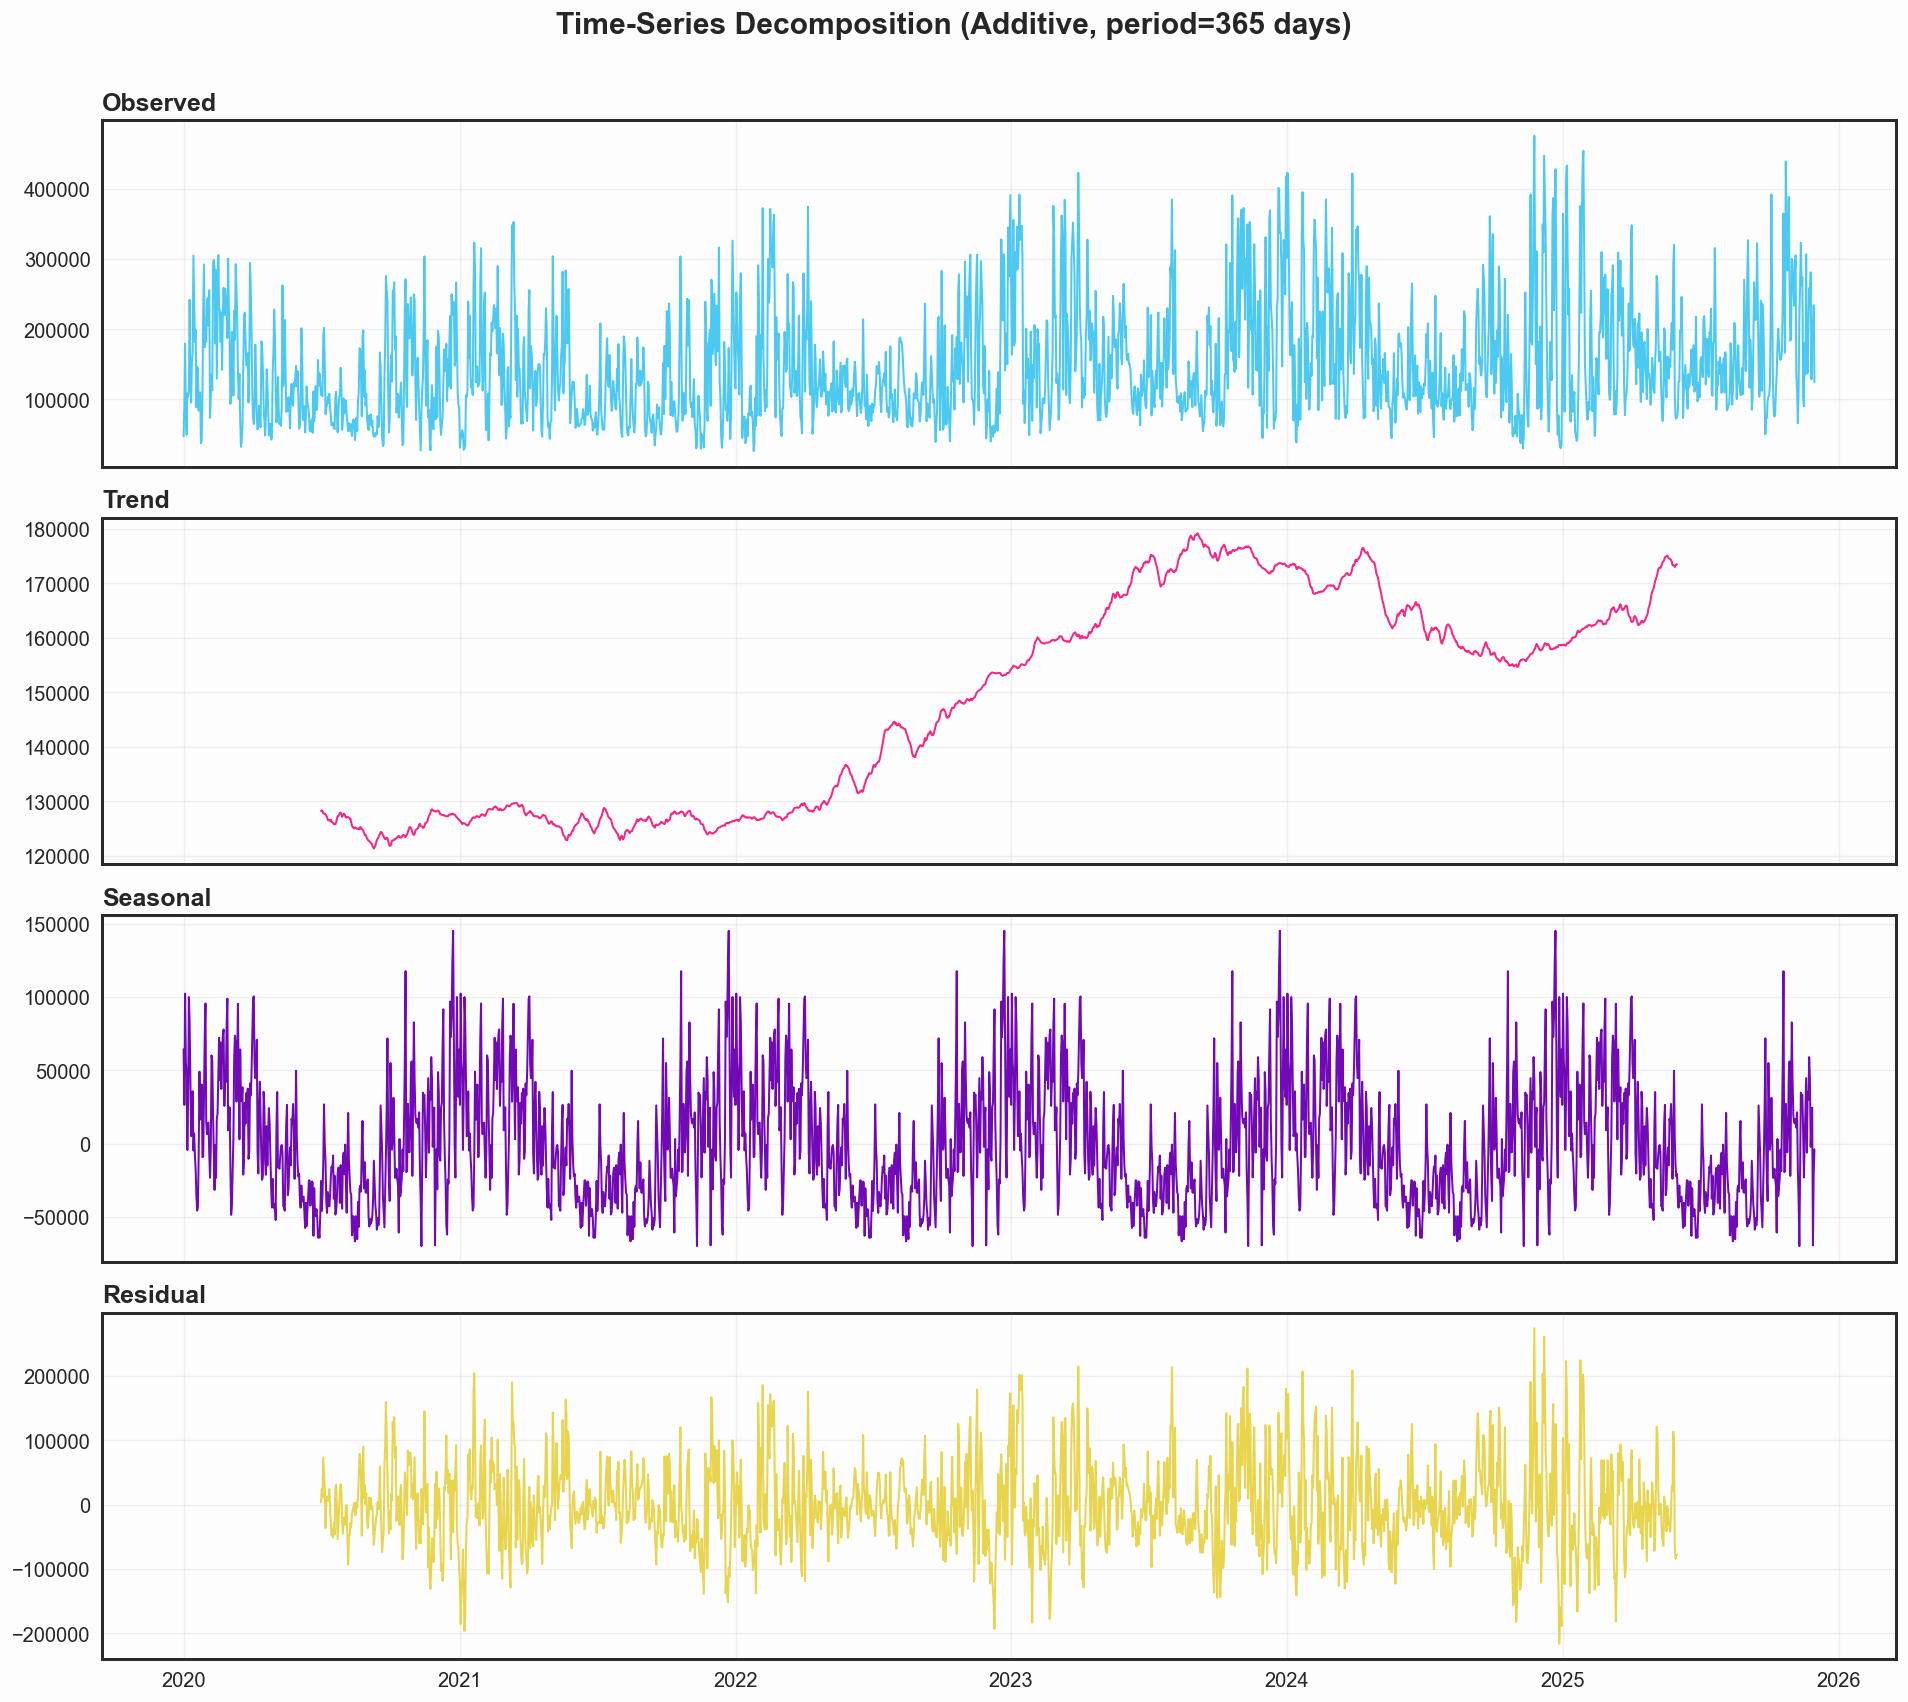

In [28]:
# PLOT 19 - Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_ts.set_index("Date")["Production"]
decomp = seasonal_decompose(ts, model="additive", period=365)

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)
titles = ["Observed", "Trend", "Seasonal", "Residual"]
data   = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
colors = ["#4CC9F0", "#F72585", "#7209B7", "#E8D44D"]

for ax, title, d, c in zip(axes, titles, data, colors):
    ax.plot(d, color=c, linewidth=1.2)
    ax.set_title(title, fontsize=15, fontweight="bold", loc="left")
    ax.grid(True, alpha=0.3)

fig.suptitle("Time-Series Decomposition (Additive, period=365 days)", fontsize=18, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("models/plot_19_decomposition.png", dpi=150, bbox_inches="tight")
plt.show()

### Key Observation - Time-Series Deep Dive

- **Trend Component:** Clear **upward trajectory** from 2020 to 2025, consistent with France's expansion of renewable capacity under the EU Green Deal.
- **Seasonal Component:** Strong annual cycle with **winter peaks** and **summer troughs** - confirming wind seasonality as the dominant pattern.
- **Residuals:** High residual variance indicates significant **short-term weather variability** remains unexplained by seasonal patterns alone.
- **Cumulative Production:** Total renewable energy produced exceeds **322 million MWh** over the 6-year observation window.
- **Year-over-Year:** 2023 consistently outperforms prior years across most months, suggesting **structural capacity gains**.

---
## 12. Peak Production & Final Summary

In [29]:
peak_month = df.groupby("Month_Name", observed=True)["Production"].mean().idxmax()
peak_month_val = df.groupby("Month_Name", observed=True)["Production"].mean().max()
peak_hour = df.groupby("Start_Hour")["Production"].mean().idxmax()
peak_hour_val = df.groupby("Start_Hour")["Production"].mean().max()
peak_season = df.groupby("Season", observed=True)["Production"].mean().idxmax()
peak_season_val = df.groupby("Season", observed=True)["Production"].mean().max()
peak_day = df.groupby("Day_Name", observed=True)["Production"].mean().idxmax()
peak_day_val = df.groupby("Day_Name", observed=True)["Production"].mean().max()
top5_days = df_ts.nlargest(5, "Production")

print("=" * 60)
print("  PEAK PRODUCTION SUMMARY")
print("=" * 60)
print(f"  Peak Month   : {peak_month}  ({peak_month_val:,.0f} MWh avg)")
print(f"  Peak Hour    : {peak_hour}:00   ({peak_hour_val:,.0f} MWh avg)")
print(f"  Peak Season  : {peak_season}    ({peak_season_val:,.0f} MWh avg)")
print(f"  Peak Day     : {peak_day}  ({peak_day_val:,.0f} MWh avg)")
print(f"\n  Top 5 Highest Production Days:")
for _, row in top5_days.iterrows():
    print(f"    {row['Date'].strftime('%Y-%m-%d')} -> {row['Production']:>10,} MWh")
print("=" * 60)

  PEAK PRODUCTION SUMMARY
  Peak Month   : February  (7,792 MWh avg)
  Peak Hour    : 13:00   (8,705 MWh avg)
  Peak Season  : Winter    (7,342 MWh avg)
  Peak Day     : Monday  (6,355 MWh avg)

  Top 5 Highest Production Days:
    2024-11-24 ->    476,113 MWh
    2025-01-28 ->    454,615 MWh
    2024-12-07 ->    447,762 MWh
    2025-10-23 ->    439,432 MWh
    2025-01-27 ->    437,039 MWh


---

## Final Key Findings & Conclusions

### Dataset Summary
| Attribute | Value |
|-----------|-------|
| Total Records | 51,862 (after removing 2 Mixed) |
| Time Coverage | Jan 2020 - Nov 2025 (2,161 days) |
| Data Quality | 100% complete, zero duplicates |
| Total Production | ~322 Million MWh |

### Top Insights

1. **Wind Dominance:** Wind energy accounts for **82%** of all records and is the backbone of France's renewable mix. However, it is inherently more volatile than solar.

2. **Solar Predictability:** Solar production follows a highly predictable diurnal bell curve (peaks at 13:00), making it easier to forecast but limited to daylight hours.

3. **Winter is King:** Counter-intuitively, **winter months produce the most energy** - driven by strong seasonal winds. Crucial for grid planning.

4. **The 2022-2023 Jump:** A structural increase in production starting in 2023 suggests new capacity installations or efficiency improvements.

5. **High Variability Challenge:** CV of ~64% underscores the **need for energy storage, demand response, and accurate forecasting**.

6. **Hourly Patterns Matter:** Wind's flat hourly profile vs Solar's bell-curve means **optimal grid management requires balancing both sources dynamically.**

7. **Day-of-Week Neutrality:** Production is purely weather-driven - **forecasting models should NOT use day-of-week as a strong feature.**

---
## 13. Forecasting - ARIMA, Prophet & LSTM

We forecast daily total production using three approaches and compare their performance.

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare data
ts_data = df_ts.set_index("Date")["Production"].sort_index()

# Train/Test split: last 60 days = test
split_idx = len(ts_data) - 60
train = ts_data.iloc[:split_idx]
test  = ts_data.iloc[split_idx:]

print(f"Train: {len(train)} days  |  Test: {len(test)} days")
print(f"Train period: {train.index[0].date()} -> {train.index[-1].date()}")
print(f"Test  period: {test.index[0].date()} -> {test.index[-1].date()}")

Train: 2101 days  |  Test: 60 days
Train period: 2020-01-01 -> 2025-10-01
Test  period: 2025-10-02 -> 2025-11-30


D:\conda_install\envs\llm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\conda_install\envs\llm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\conda_install\envs\llm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


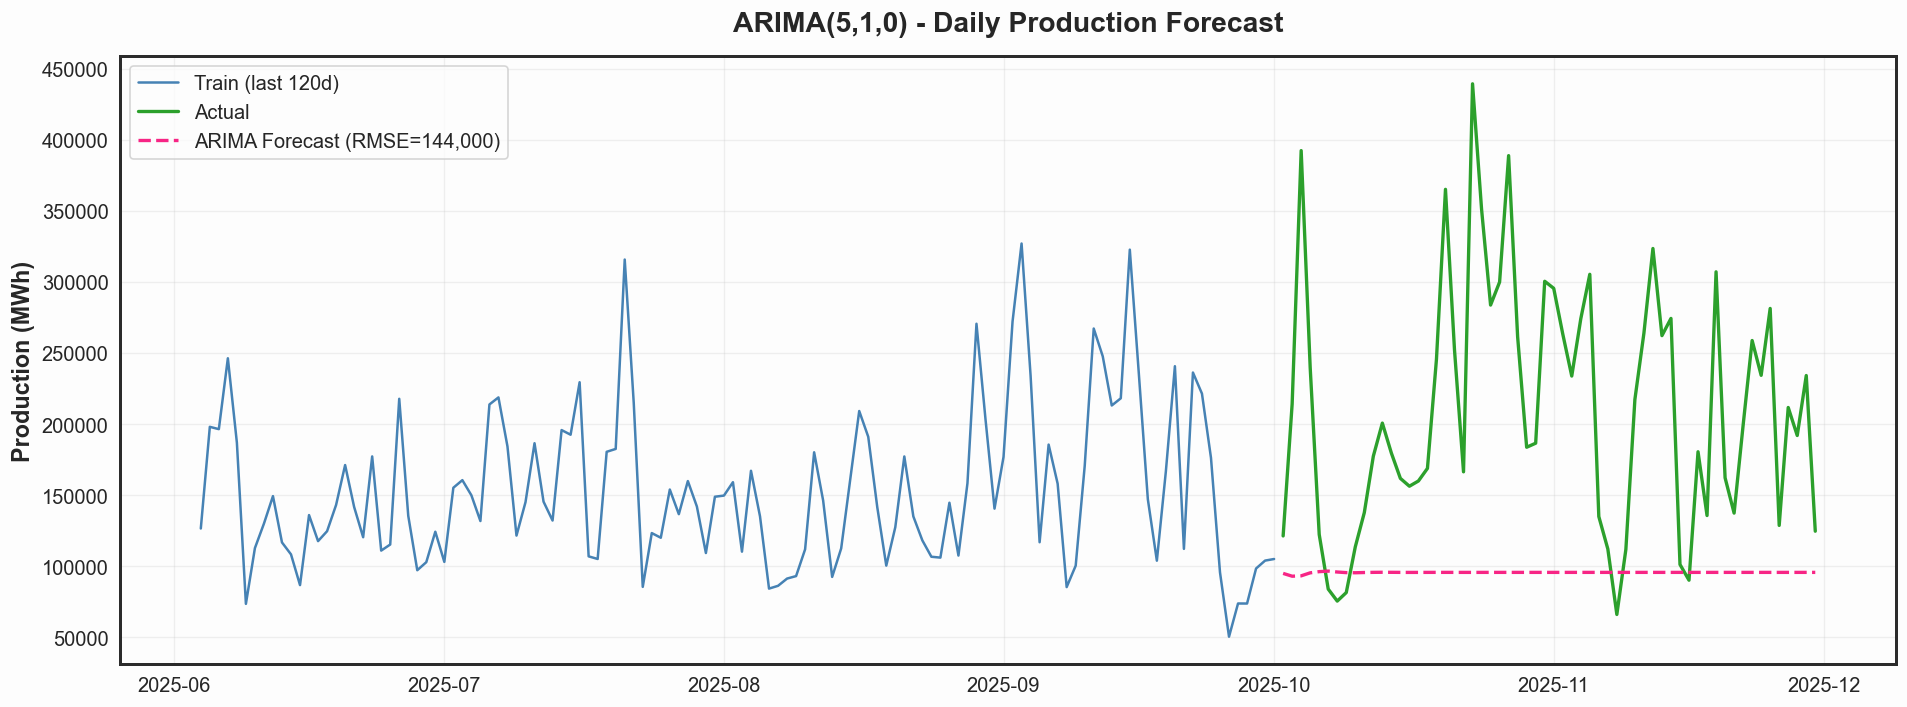

ARIMA  -> RMSE: 144,000  |  MAE: 117,678
ARIMA model saved to models/arima_model.pkl


In [31]:
# MODEL 1: ARIMA(5,1,0)
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast.index = test.index

arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train[-120:], label="Train (last 120d)", color="steelblue", linewidth=1.5)
ax.plot(test, label="Actual", color="#2ca02c", linewidth=2)
ax.plot(arima_forecast, label=f"ARIMA Forecast (RMSE={arima_rmse:,.0f})", color="#F72585", linewidth=2, linestyle="--")
ax.set_title("ARIMA(5,1,0) - Daily Production Forecast", pad=15)
ax.set_ylabel("Production (MWh)"); ax.legend(fontsize=12); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_20_arima.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"ARIMA  -> RMSE: {arima_rmse:,.0f}  |  MAE: {arima_mae:,.0f}")

# Save ARIMA model
arima_fit.save("models/arima_model.pkl")
print("ARIMA model saved to models/arima_model.pkl")

17:15:36 - cmdstanpy - INFO - Chain [1] start processing


17:15:36 - cmdstanpy - INFO - Chain [1] done processing


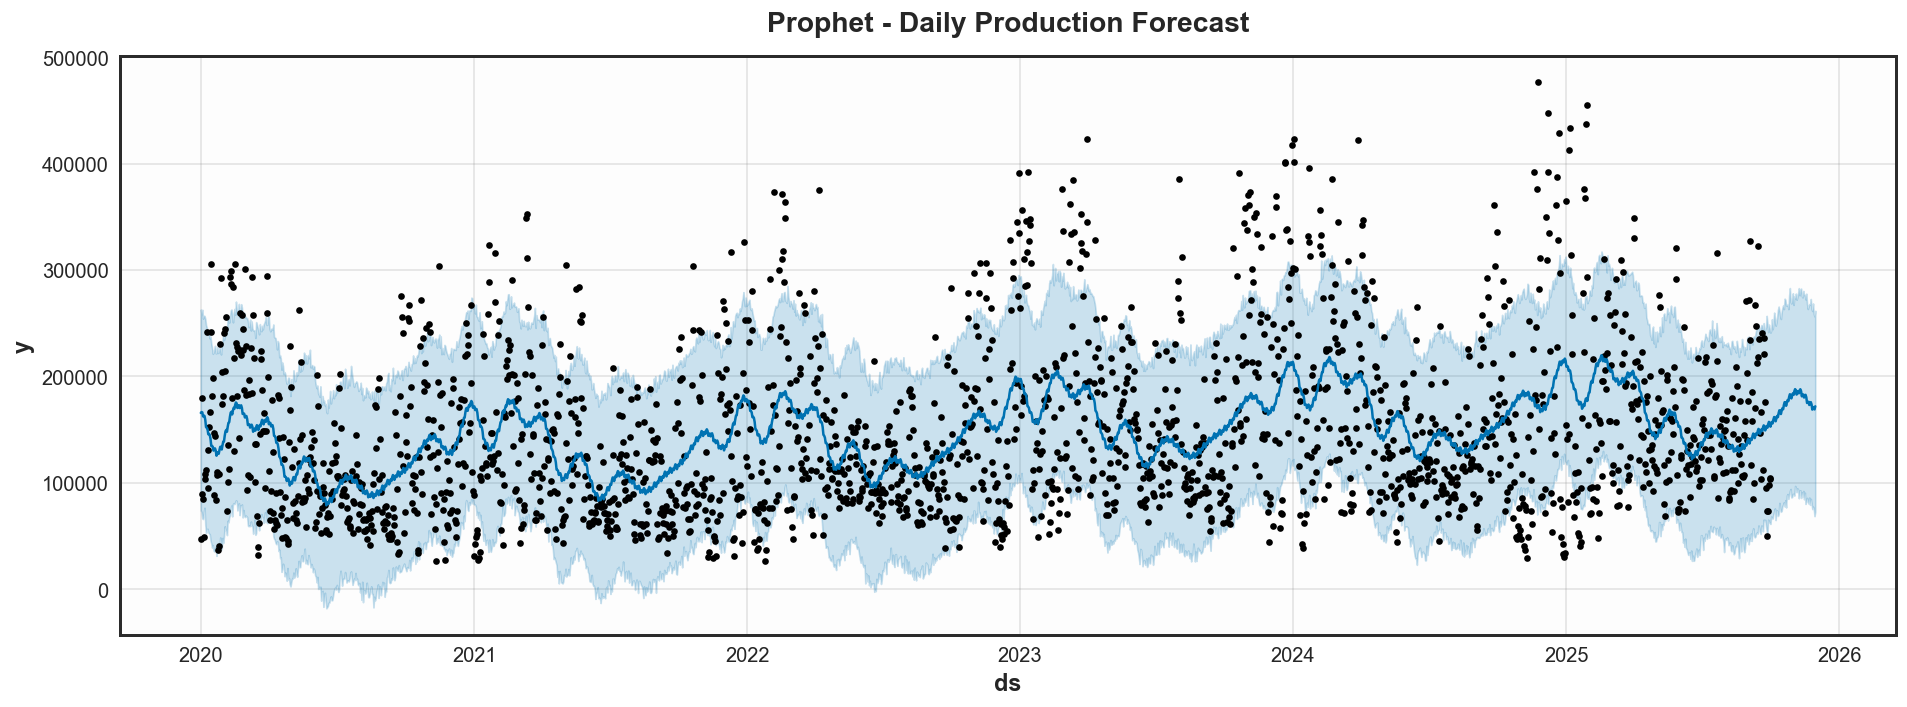

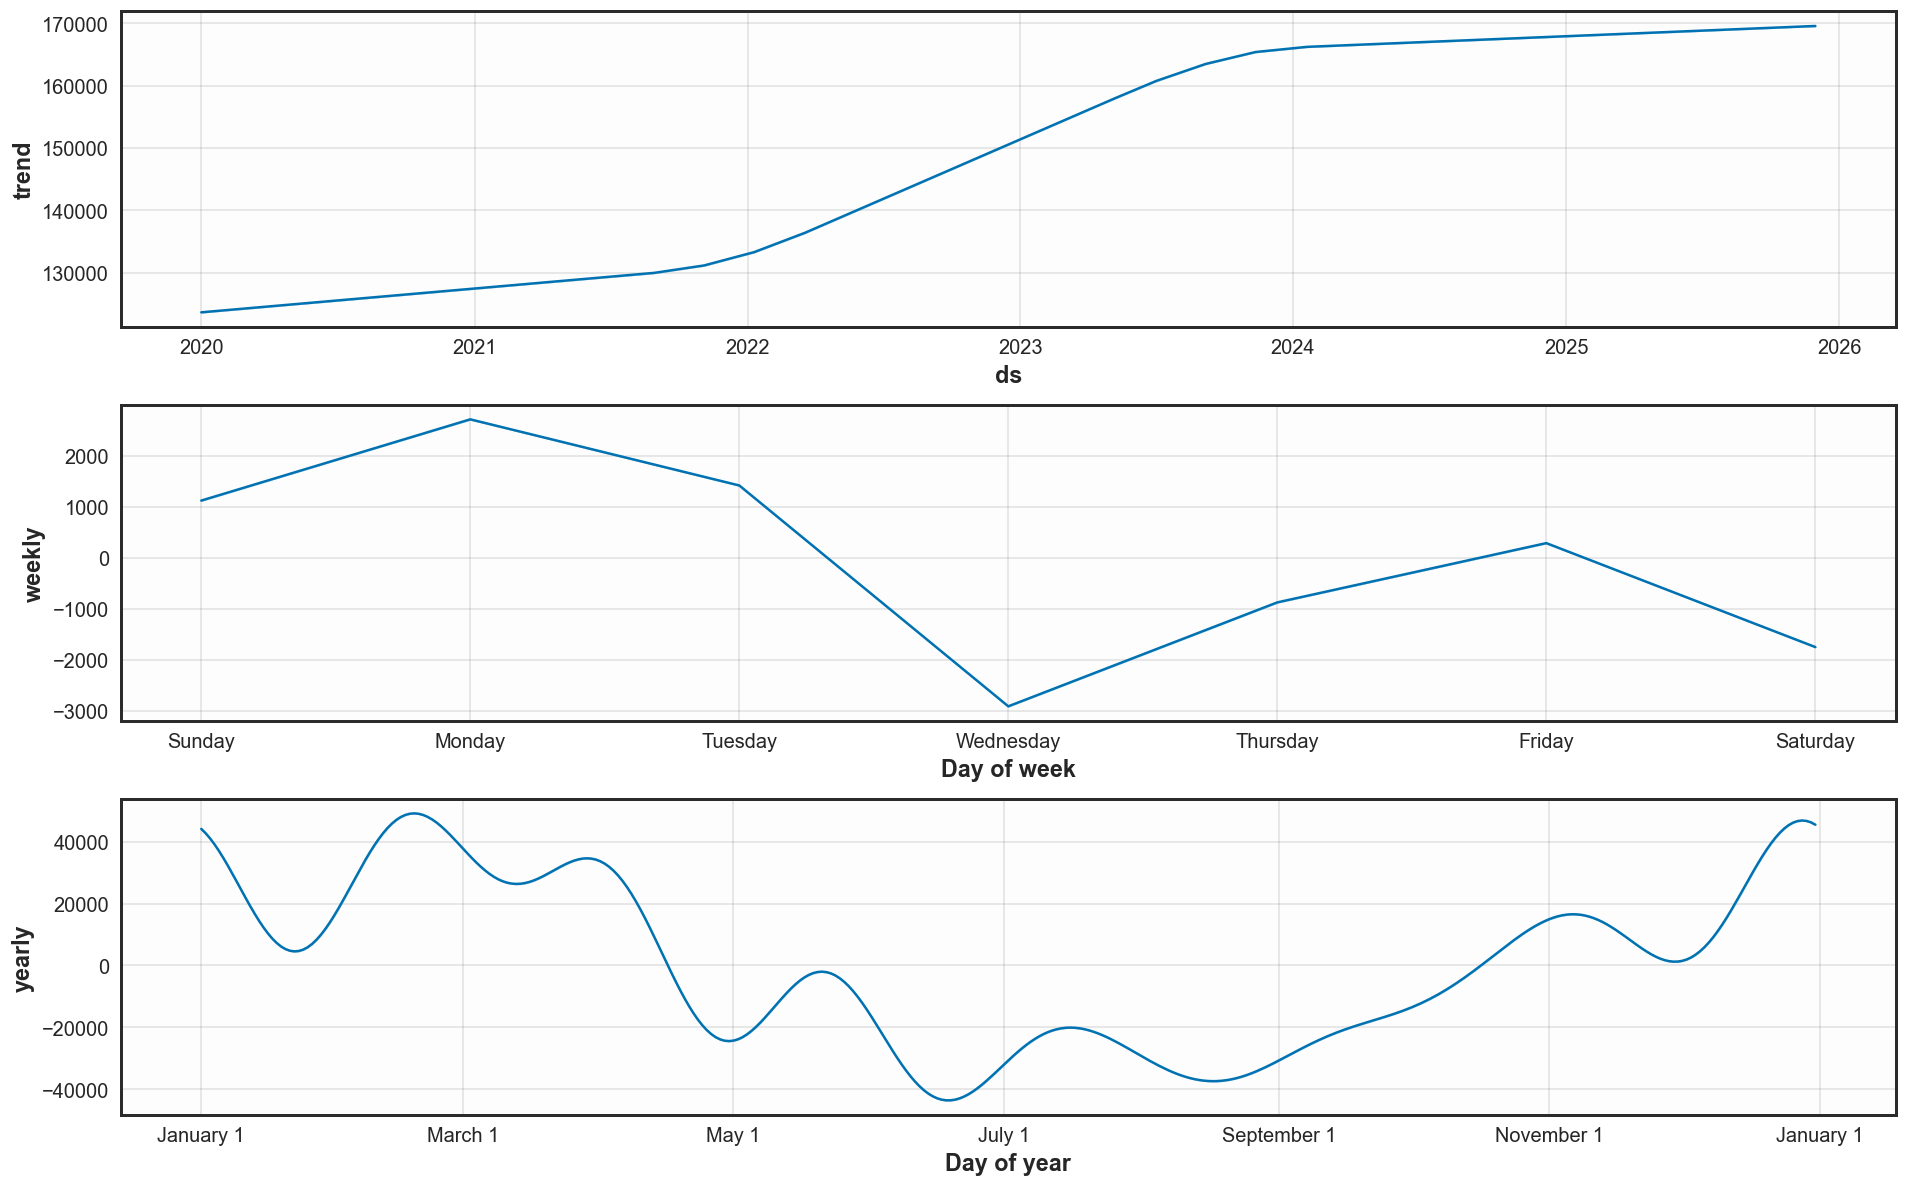

Prophet -> RMSE: 92,002  |  MAE: 72,233
Prophet model saved to models/prophet_model.pkl


In [32]:
# MODEL 2: Prophet
from prophet import Prophet

prophet_df = train.reset_index()
prophet_df.columns = ["ds", "y"]

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=len(test), freq="D")
prophet_forecast = prophet_model.predict(future)

prophet_pred = prophet_forecast.set_index("ds").loc[test.index, "yhat"]
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_pred))
prophet_mae = mean_absolute_error(test, prophet_pred)

fig = prophet_model.plot(prophet_forecast, figsize=(16, 6))
plt.title("Prophet - Daily Production Forecast", fontsize=17, fontweight="bold", pad=15)
plt.tight_layout()
plt.savefig("models/plot_21_prophet.png", dpi=150, bbox_inches="tight")
plt.show()

fig2 = prophet_model.plot_components(prophet_forecast, figsize=(16, 10))
plt.tight_layout()
plt.savefig("models/plot_22_prophet_components.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Prophet -> RMSE: {prophet_rmse:,.0f}  |  MAE: {prophet_mae:,.0f}")

# Save Prophet model
import pickle
with open("models/prophet_model.pkl", "wb") as f:
    pickle.dump(prophet_model, f)
print("Prophet model saved to models/prophet_model.pkl")

In [33]:
# MODEL 3: LSTM
from sklearn.preprocessing import MinMaxScaler

values = df_ts["Production"].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

lookback = 60
X_all, y_all = [], []
for i in range(lookback, len(scaled)):
    X_all.append(scaled[i - lookback:i, 0])
    y_all.append(scaled[i, 0])
X_all, y_all = np.array(X_all), np.array(y_all)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

split_idx_lstm = len(X_all) - len(test)
X_train, X_test = X_all[:split_idx_lstm], X_all[split_idx_lstm:]
y_train, y_test = y_all[:split_idx_lstm], y_all[split_idx_lstm:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 60, 64)            16896     


 dropout (Dropout)           (None, 60, 64)            0         


 lstm_1 (LSTM)               (None, 64)                33024     


 dropout_1 (Dropout)         (None, 64)                0         


 dense (Dense)               (None, 1)                 65        


Total params: 49985 (195.25 KB)


Trainable params: 49985 (195.25 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/15


 1/58 [..............................] - ETA: 8:01 - loss: 0.1015

 2/58 [>.............................] - ETA: 3s - loss: 0.0758  

 4/58 [=>............................] - ETA: 2s - loss: 0.0558

 6/58 [==>...........................] - ETA: 2s - loss: 0.0455

 8/58 [===>..........................] - ETA: 2s - loss: 0.0423

 9/58 [===>..........................] - ETA: 2s - loss: 0.0409

11/58 [====>.........................] - ETA: 2s - loss: 0.0380

13/58 [=====>........................] - ETA: 2s - loss: 0.0375

15/58 [======>.......................] - ETA: 1s - loss: 0.0388

17/58 [=======>......................] - ETA: 1s - loss: 0.0385

19/58 [========>.....................] - ETA: 1s - loss: 0.0375

20/58 [=========>....................] - ETA: 1s - loss: 0.0371

22/58 [==========>...................] - ETA: 1s - loss: 0.0351

24/58 [===========>..................] - ETA: 1s - loss: 0.0346

26/58 [============>.................] - ETA: 1s - loss: 0.0350

28/58 [=============>................] - ETA: 1s - loss: 0.0349

30/58 [==============>...............] - ETA: 1s - loss: 0.0343

31/58 [===============>..............] - ETA: 1s - loss: 0.0336

33/58 [================>.............] - ETA: 1s - loss: 0.0329

35/58 [=================>............] - ETA: 1s - loss: 0.0325

37/58 [==================>...........] - ETA: 0s - loss: 0.0324

39/58 [===================>..........] - ETA: 0s - loss: 0.0326

41/58 [====================>.........] - ETA: 0s - loss: 0.0331

43/58 [=====================>........] - ETA: 0s - loss: 0.0333

45/58 [======================>.......] - ETA: 0s - loss: 0.0331

47/58 [=======================>......] - ETA: 0s - loss: 0.0329

49/58 [========================>.....] - ETA: 0s - loss: 0.0333

51/58 [=========================>....] - ETA: 0s - loss: 0.0331

53/58 [==========================>...] - ETA: 0s - loss: 0.0329

55/58 [===========================>..] - ETA: 0s - loss: 0.0327

57/58 [============================>.] - ETA: 0s - loss: 0.0326

58/58 [==============================] - 13s 85ms/step - loss: 0.0324 - val_loss: 0.0179


Epoch 2/15


 1/58 [..............................] - ETA: 3s - loss: 0.0407

 2/58 [>.............................] - ETA: 3s - loss: 0.0344

 3/58 [>.............................] - ETA: 3s - loss: 0.0328

 4/58 [=>............................] - ETA: 2s - loss: 0.0299

 6/58 [==>...........................] - ETA: 2s - loss: 0.0310

 7/58 [==>...........................] - ETA: 2s - loss: 0.0297

 8/58 [===>..........................] - ETA: 2s - loss: 0.0287

 9/58 [===>..........................] - ETA: 2s - loss: 0.0290

10/58 [====>.........................] - ETA: 2s - loss: 0.0276

11/58 [====>.........................] - ETA: 2s - loss: 0.0277

12/58 [=====>........................] - ETA: 2s - loss: 0.0285

13/58 [=====>........................] - ETA: 2s - loss: 0.0288

14/58 [======>.......................] - ETA: 2s - loss: 0.0291

15/58 [======>.......................] - ETA: 2s - loss: 0.0284

16/58 [=======>......................] - ETA: 2s - loss: 0.0291

17/58 [=======>......................] - ETA: 2s - loss: 0.0291

18/58 [========>.....................] - ETA: 2s - loss: 0.0284

19/58 [========>.....................] - ETA: 2s - loss: 0.0280

20/58 [=========>....................] - ETA: 2s - loss: 0.0276

21/58 [=========>....................] - ETA: 1s - loss: 0.0283

22/58 [==========>...................] - ETA: 1s - loss: 0.0286

23/58 [==========>...................] - ETA: 1s - loss: 0.0286

24/58 [===========>..................] - ETA: 1s - loss: 0.0289

25/58 [===========>..................] - ETA: 1s - loss: 0.0290

26/58 [============>.................] - ETA: 1s - loss: 0.0286

27/58 [============>.................] - ETA: 1s - loss: 0.0286

28/58 [=============>................] - ETA: 1s - loss: 0.0284

29/58 [==============>...............] - ETA: 1s - loss: 0.0286

30/58 [==============>...............] - ETA: 1s - loss: 0.0284

31/58 [===============>..............] - ETA: 1s - loss: 0.0280

32/58 [===============>..............] - ETA: 1s - loss: 0.0280

33/58 [================>.............] - ETA: 1s - loss: 0.0278

35/58 [=================>............] - ETA: 1s - loss: 0.0280

36/58 [=================>............] - ETA: 1s - loss: 0.0278

37/58 [==================>...........] - ETA: 1s - loss: 0.0273

38/58 [==================>...........] - ETA: 1s - loss: 0.0276

39/58 [===================>..........] - ETA: 1s - loss: 0.0275

40/58 [===================>..........] - ETA: 0s - loss: 0.0276

41/58 [====================>.........] - ETA: 0s - loss: 0.0277

42/58 [====================>.........] - ETA: 0s - loss: 0.0278

43/58 [=====================>........] - ETA: 0s - loss: 0.0277

44/58 [=====================>........] - ETA: 0s - loss: 0.0279

45/58 [======================>.......] - ETA: 0s - loss: 0.0277

46/58 [======================>.......] - ETA: 0s - loss: 0.0277

47/58 [=======================>......] - ETA: 0s - loss: 0.0276

49/58 [========================>.....] - ETA: 0s - loss: 0.0277

50/58 [========================>.....] - ETA: 0s - loss: 0.0276

51/58 [=========================>....] - ETA: 0s - loss: 0.0276

52/58 [=========================>....] - ETA: 0s - loss: 0.0276

54/58 [==========================>...] - ETA: 0s - loss: 0.0277

56/58 [===========================>..] - ETA: 0s - loss: 0.0275

57/58 [============================>.] - ETA: 0s - loss: 0.0273

58/58 [==============================] - 3s 56ms/step - loss: 0.0272 - val_loss: 0.0172


Epoch 3/15


 1/58 [..............................] - ETA: 3s - loss: 0.0256

 2/58 [>.............................] - ETA: 2s - loss: 0.0236

 3/58 [>.............................] - ETA: 2s - loss: 0.0204

 4/58 [=>............................] - ETA: 2s - loss: 0.0218

 5/58 [=>............................] - ETA: 3s - loss: 0.0235

 6/58 [==>...........................] - ETA: 3s - loss: 0.0229

 7/58 [==>...........................] - ETA: 3s - loss: 0.0245

 8/58 [===>..........................] - ETA: 3s - loss: 0.0237

 9/58 [===>..........................] - ETA: 3s - loss: 0.0247

10/58 [====>.........................] - ETA: 3s - loss: 0.0251

11/58 [====>.........................] - ETA: 3s - loss: 0.0249

12/58 [=====>........................] - ETA: 3s - loss: 0.0252

13/58 [=====>........................] - ETA: 2s - loss: 0.0254

14/58 [======>.......................] - ETA: 2s - loss: 0.0258

15/58 [======>.......................] - ETA: 2s - loss: 0.0253

16/58 [=======>......................] - ETA: 2s - loss: 0.0255

17/58 [=======>......................] - ETA: 2s - loss: 0.0250

18/58 [========>.....................] - ETA: 2s - loss: 0.0246

19/58 [========>.....................] - ETA: 2s - loss: 0.0243

21/58 [=========>....................] - ETA: 2s - loss: 0.0247

22/58 [==========>...................] - ETA: 2s - loss: 0.0251

23/58 [==========>...................] - ETA: 2s - loss: 0.0255

24/58 [===========>..................] - ETA: 2s - loss: 0.0262

25/58 [===========>..................] - ETA: 1s - loss: 0.0262

26/58 [============>.................] - ETA: 1s - loss: 0.0265

27/58 [============>.................] - ETA: 1s - loss: 0.0267

28/58 [=============>................] - ETA: 1s - loss: 0.0267

29/58 [==============>...............] - ETA: 1s - loss: 0.0263

30/58 [==============>...............] - ETA: 1s - loss: 0.0262

31/58 [===============>..............] - ETA: 1s - loss: 0.0262

33/58 [================>.............] - ETA: 1s - loss: 0.0262

35/58 [=================>............] - ETA: 1s - loss: 0.0263

36/58 [=================>............] - ETA: 1s - loss: 0.0261

37/58 [==================>...........] - ETA: 1s - loss: 0.0260

38/58 [==================>...........] - ETA: 1s - loss: 0.0258

40/58 [===================>..........] - ETA: 1s - loss: 0.0261

41/58 [====================>.........] - ETA: 0s - loss: 0.0262

42/58 [====================>.........] - ETA: 0s - loss: 0.0262

43/58 [=====================>........] - ETA: 0s - loss: 0.0264

44/58 [=====================>........] - ETA: 0s - loss: 0.0268

45/58 [======================>.......] - ETA: 0s - loss: 0.0268

47/58 [=======================>......] - ETA: 0s - loss: 0.0269

48/58 [=======================>......] - ETA: 0s - loss: 0.0269

49/58 [========================>.....] - ETA: 0s - loss: 0.0270

50/58 [========================>.....] - ETA: 0s - loss: 0.0270

51/58 [=========================>....] - ETA: 0s - loss: 0.0269

52/58 [=========================>....] - ETA: 0s - loss: 0.0269

53/58 [==========================>...] - ETA: 0s - loss: 0.0266

54/58 [==========================>...] - ETA: 0s - loss: 0.0265

55/58 [===========================>..] - ETA: 0s - loss: 0.0266

56/58 [===========================>..] - ETA: 0s - loss: 0.0265

57/58 [============================>.] - ETA: 0s - loss: 0.0267

58/58 [==============================] - 3s 58ms/step - loss: 0.0266 - val_loss: 0.0173


Epoch 4/15


 1/58 [..............................] - ETA: 3s - loss: 0.0265

 2/58 [>.............................] - ETA: 2s - loss: 0.0255

 3/58 [>.............................] - ETA: 2s - loss: 0.0272

 4/58 [=>............................] - ETA: 2s - loss: 0.0236

 5/58 [=>............................] - ETA: 2s - loss: 0.0228

 6/58 [==>...........................] - ETA: 2s - loss: 0.0237

 7/58 [==>...........................] - ETA: 2s - loss: 0.0221

 8/58 [===>..........................] - ETA: 2s - loss: 0.0213

 9/58 [===>..........................] - ETA: 2s - loss: 0.0210

10/58 [====>.........................] - ETA: 2s - loss: 0.0217

11/58 [====>.........................] - ETA: 2s - loss: 0.0222

12/58 [=====>........................] - ETA: 2s - loss: 0.0226

13/58 [=====>........................] - ETA: 2s - loss: 0.0221

14/58 [======>.......................] - ETA: 2s - loss: 0.0226

15/58 [======>.......................] - ETA: 2s - loss: 0.0229

16/58 [=======>......................] - ETA: 2s - loss: 0.0228

17/58 [=======>......................] - ETA: 2s - loss: 0.0231

18/58 [========>.....................] - ETA: 2s - loss: 0.0229

20/58 [=========>....................] - ETA: 2s - loss: 0.0232

22/58 [==========>...................] - ETA: 1s - loss: 0.0228

23/58 [==========>...................] - ETA: 1s - loss: 0.0228

24/58 [===========>..................] - ETA: 1s - loss: 0.0230

25/58 [===========>..................] - ETA: 1s - loss: 0.0239

26/58 [============>.................] - ETA: 1s - loss: 0.0238

27/58 [============>.................] - ETA: 1s - loss: 0.0243

28/58 [=============>................] - ETA: 1s - loss: 0.0246

29/58 [==============>...............] - ETA: 1s - loss: 0.0249

30/58 [==============>...............] - ETA: 1s - loss: 0.0254

31/58 [===============>..............] - ETA: 1s - loss: 0.0256

32/58 [===============>..............] - ETA: 1s - loss: 0.0257

33/58 [================>.............] - ETA: 1s - loss: 0.0255

34/58 [================>.............] - ETA: 1s - loss: 0.0258

36/58 [=================>............] - ETA: 1s - loss: 0.0256

37/58 [==================>...........] - ETA: 1s - loss: 0.0255

38/58 [==================>...........] - ETA: 1s - loss: 0.0254

39/58 [===================>..........] - ETA: 0s - loss: 0.0250

40/58 [===================>..........] - ETA: 0s - loss: 0.0250

41/58 [====================>.........] - ETA: 0s - loss: 0.0246

42/58 [====================>.........] - ETA: 0s - loss: 0.0245

43/58 [=====================>........] - ETA: 0s - loss: 0.0245

44/58 [=====================>........] - ETA: 0s - loss: 0.0244

45/58 [======================>.......] - ETA: 0s - loss: 0.0244

46/58 [======================>.......] - ETA: 0s - loss: 0.0250

47/58 [=======================>......] - ETA: 0s - loss: 0.0250

48/58 [=======================>......] - ETA: 0s - loss: 0.0248

49/58 [========================>.....] - ETA: 0s - loss: 0.0247

50/58 [========================>.....] - ETA: 0s - loss: 0.0245

51/58 [=========================>....] - ETA: 0s - loss: 0.0248

52/58 [=========================>....] - ETA: 0s - loss: 0.0246

53/58 [==========================>...] - ETA: 0s - loss: 0.0244

54/58 [==========================>...] - ETA: 0s - loss: 0.0243

55/58 [===========================>..] - ETA: 0s - loss: 0.0244

56/58 [===========================>..] - ETA: 0s - loss: 0.0246

57/58 [============================>.] - ETA: 0s - loss: 0.0246

58/58 [==============================] - ETA: 0s - loss: 0.0246

58/58 [==============================] - 5s 88ms/step - loss: 0.0246 - val_loss: 0.0162


Epoch 5/15


 1/58 [..............................] - ETA: 5s - loss: 0.0248

 2/58 [>.............................] - ETA: 5s - loss: 0.0253

 3/58 [>.............................] - ETA: 4s - loss: 0.0273

 4/58 [=>............................] - ETA: 4s - loss: 0.0258

 5/58 [=>............................] - ETA: 4s - loss: 0.0260

 6/58 [==>...........................] - ETA: 4s - loss: 0.0242

 7/58 [==>...........................] - ETA: 4s - loss: 0.0237

 8/58 [===>..........................] - ETA: 4s - loss: 0.0234

 9/58 [===>..........................] - ETA: 4s - loss: 0.0233

10/58 [====>.........................] - ETA: 4s - loss: 0.0231

11/58 [====>.........................] - ETA: 3s - loss: 0.0232

12/58 [=====>........................] - ETA: 3s - loss: 0.0241

13/58 [=====>........................] - ETA: 3s - loss: 0.0242

14/58 [======>.......................] - ETA: 3s - loss: 0.0253

15/58 [======>.......................] - ETA: 3s - loss: 0.0248

16/58 [=======>......................] - ETA: 3s - loss: 0.0250

17/58 [=======>......................] - ETA: 3s - loss: 0.0242

18/58 [========>.....................] - ETA: 3s - loss: 0.0241

19/58 [========>.....................] - ETA: 3s - loss: 0.0240

20/58 [=========>....................] - ETA: 2s - loss: 0.0240

21/58 [=========>....................] - ETA: 2s - loss: 0.0239

22/58 [==========>...................] - ETA: 2s - loss: 0.0242

23/58 [==========>...................] - ETA: 2s - loss: 0.0238

24/58 [===========>..................] - ETA: 2s - loss: 0.0245

25/58 [===========>..................] - ETA: 2s - loss: 0.0246

26/58 [============>.................] - ETA: 2s - loss: 0.0251

27/58 [============>.................] - ETA: 2s - loss: 0.0251

28/58 [=============>................] - ETA: 2s - loss: 0.0253

29/58 [==============>...............] - ETA: 2s - loss: 0.0254

30/58 [==============>...............] - ETA: 2s - loss: 0.0250

31/58 [===============>..............] - ETA: 2s - loss: 0.0253

32/58 [===============>..............] - ETA: 1s - loss: 0.0258

33/58 [================>.............] - ETA: 1s - loss: 0.0255

34/58 [================>.............] - ETA: 1s - loss: 0.0258

35/58 [=================>............] - ETA: 1s - loss: 0.0255

36/58 [=================>............] - ETA: 1s - loss: 0.0255

37/58 [==================>...........] - ETA: 1s - loss: 0.0253

38/58 [==================>...........] - ETA: 1s - loss: 0.0251

39/58 [===================>..........] - ETA: 1s - loss: 0.0249

40/58 [===================>..........] - ETA: 1s - loss: 0.0247

41/58 [====================>.........] - ETA: 1s - loss: 0.0248

42/58 [====================>.........] - ETA: 1s - loss: 0.0246

43/58 [=====================>........] - ETA: 1s - loss: 0.0246

44/58 [=====================>........] - ETA: 1s - loss: 0.0247

45/58 [======================>.......] - ETA: 0s - loss: 0.0245

46/58 [======================>.......] - ETA: 0s - loss: 0.0245

47/58 [=======================>......] - ETA: 0s - loss: 0.0243

48/58 [=======================>......] - ETA: 0s - loss: 0.0244

49/58 [========================>.....] - ETA: 0s - loss: 0.0243

50/58 [========================>.....] - ETA: 0s - loss: 0.0243

51/58 [=========================>....] - ETA: 0s - loss: 0.0242

52/58 [=========================>....] - ETA: 0s - loss: 0.0242

53/58 [==========================>...] - ETA: 0s - loss: 0.0241

54/58 [==========================>...] - ETA: 0s - loss: 0.0241

55/58 [===========================>..] - ETA: 0s - loss: 0.0243

56/58 [===========================>..] - ETA: 0s - loss: 0.0242

57/58 [============================>.] - ETA: 0s - loss: 0.0241

58/58 [==============================] - ETA: 0s - loss: 0.0244

58/58 [==============================] - 4s 76ms/step - loss: 0.0244 - val_loss: 0.0156


Epoch 6/15


 1/58 [..............................] - ETA: 4s - loss: 0.0114

 2/58 [>.............................] - ETA: 3s - loss: 0.0169

 3/58 [>.............................] - ETA: 3s - loss: 0.0165

 4/58 [=>............................] - ETA: 3s - loss: 0.0179

 5/58 [=>............................] - ETA: 3s - loss: 0.0175

 6/58 [==>...........................] - ETA: 3s - loss: 0.0201

 7/58 [==>...........................] - ETA: 3s - loss: 0.0219

 8/58 [===>..........................] - ETA: 3s - loss: 0.0215

 9/58 [===>..........................] - ETA: 3s - loss: 0.0223

10/58 [====>.........................] - ETA: 3s - loss: 0.0227

11/58 [====>.........................] - ETA: 3s - loss: 0.0222

12/58 [=====>........................] - ETA: 3s - loss: 0.0215

13/58 [=====>........................] - ETA: 3s - loss: 0.0217

14/58 [======>.......................] - ETA: 3s - loss: 0.0226

15/58 [======>.......................] - ETA: 3s - loss: 0.0231

16/58 [=======>......................] - ETA: 3s - loss: 0.0235

17/58 [=======>......................] - ETA: 3s - loss: 0.0238

18/58 [========>.....................] - ETA: 3s - loss: 0.0239

19/58 [========>.....................] - ETA: 2s - loss: 0.0242

20/58 [=========>....................] - ETA: 2s - loss: 0.0247

21/58 [=========>....................] - ETA: 2s - loss: 0.0247

22/58 [==========>...................] - ETA: 2s - loss: 0.0247

23/58 [==========>...................] - ETA: 2s - loss: 0.0242

24/58 [===========>..................] - ETA: 2s - loss: 0.0243

25/58 [===========>..................] - ETA: 2s - loss: 0.0246

26/58 [============>.................] - ETA: 2s - loss: 0.0245

27/58 [============>.................] - ETA: 2s - loss: 0.0241

28/58 [=============>................] - ETA: 2s - loss: 0.0238

29/58 [==============>...............] - ETA: 2s - loss: 0.0239

30/58 [==============>...............] - ETA: 2s - loss: 0.0235

31/58 [===============>..............] - ETA: 2s - loss: 0.0232

32/58 [===============>..............] - ETA: 2s - loss: 0.0230

33/58 [================>.............] - ETA: 2s - loss: 0.0234

34/58 [================>.............] - ETA: 2s - loss: 0.0233

35/58 [=================>............] - ETA: 2s - loss: 0.0230

36/58 [=================>............] - ETA: 1s - loss: 0.0230

37/58 [==================>...........] - ETA: 1s - loss: 0.0231

38/58 [==================>...........] - ETA: 1s - loss: 0.0231

39/58 [===================>..........] - ETA: 1s - loss: 0.0230

40/58 [===================>..........] - ETA: 1s - loss: 0.0232

41/58 [====================>.........] - ETA: 1s - loss: 0.0235

42/58 [====================>.........] - ETA: 1s - loss: 0.0234

43/58 [=====================>........] - ETA: 1s - loss: 0.0232

44/58 [=====================>........] - ETA: 1s - loss: 0.0231

45/58 [======================>.......] - ETA: 1s - loss: 0.0229

46/58 [======================>.......] - ETA: 0s - loss: 0.0230

47/58 [=======================>......] - ETA: 0s - loss: 0.0231

48/58 [=======================>......] - ETA: 0s - loss: 0.0231

49/58 [========================>.....] - ETA: 0s - loss: 0.0232

50/58 [========================>.....] - ETA: 0s - loss: 0.0232

51/58 [=========================>....] - ETA: 0s - loss: 0.0232

52/58 [=========================>....] - ETA: 0s - loss: 0.0232

53/58 [==========================>...] - ETA: 0s - loss: 0.0233

54/58 [==========================>...] - ETA: 0s - loss: 0.0233

55/58 [===========================>..] - ETA: 0s - loss: 0.0230

56/58 [===========================>..] - ETA: 0s - loss: 0.0230

57/58 [============================>.] - ETA: 0s - loss: 0.0228

58/58 [==============================] - ETA: 0s - loss: 0.0231

58/58 [==============================] - 5s 84ms/step - loss: 0.0231 - val_loss: 0.0164


Epoch 7/15


 1/58 [..............................] - ETA: 7s - loss: 0.0210

 2/58 [>.............................] - ETA: 9s - loss: 0.0232

 3/58 [>.............................] - ETA: 8s - loss: 0.0208

 4/58 [=>............................] - ETA: 7s - loss: 0.0206

 5/58 [=>............................] - ETA: 7s - loss: 0.0210

 6/58 [==>...........................] - ETA: 6s - loss: 0.0203

 7/58 [==>...........................] - ETA: 6s - loss: 0.0200

 8/58 [===>..........................] - ETA: 5s - loss: 0.0195

 9/58 [===>..........................] - ETA: 5s - loss: 0.0215

10/58 [====>.........................] - ETA: 5s - loss: 0.0213

11/58 [====>.........................] - ETA: 4s - loss: 0.0218

12/58 [=====>........................] - ETA: 4s - loss: 0.0219

13/58 [=====>........................] - ETA: 4s - loss: 0.0225

14/58 [======>.......................] - ETA: 4s - loss: 0.0231

15/58 [======>.......................] - ETA: 4s - loss: 0.0230

16/58 [=======>......................] - ETA: 3s - loss: 0.0222

17/58 [=======>......................] - ETA: 3s - loss: 0.0223

18/58 [========>.....................] - ETA: 3s - loss: 0.0219

19/58 [========>.....................] - ETA: 3s - loss: 0.0224

20/58 [=========>....................] - ETA: 3s - loss: 0.0227

21/58 [=========>....................] - ETA: 3s - loss: 0.0222

22/58 [==========>...................] - ETA: 3s - loss: 0.0222

23/58 [==========>...................] - ETA: 3s - loss: 0.0220

24/58 [===========>..................] - ETA: 2s - loss: 0.0223

25/58 [===========>..................] - ETA: 2s - loss: 0.0222

26/58 [============>.................] - ETA: 2s - loss: 0.0225

27/58 [============>.................] - ETA: 2s - loss: 0.0223

28/58 [=============>................] - ETA: 2s - loss: 0.0224

29/58 [==============>...............] - ETA: 2s - loss: 0.0223

30/58 [==============>...............] - ETA: 2s - loss: 0.0223

31/58 [===============>..............] - ETA: 2s - loss: 0.0224

32/58 [===============>..............] - ETA: 2s - loss: 0.0224

33/58 [================>.............] - ETA: 2s - loss: 0.0224

34/58 [================>.............] - ETA: 1s - loss: 0.0222

35/58 [=================>............] - ETA: 1s - loss: 0.0221

36/58 [=================>............] - ETA: 1s - loss: 0.0222

37/58 [==================>...........] - ETA: 1s - loss: 0.0221

38/58 [==================>...........] - ETA: 1s - loss: 0.0222

39/58 [===================>..........] - ETA: 1s - loss: 0.0224

40/58 [===================>..........] - ETA: 1s - loss: 0.0221

41/58 [====================>.........] - ETA: 1s - loss: 0.0220

42/58 [====================>.........] - ETA: 1s - loss: 0.0220

43/58 [=====================>........] - ETA: 1s - loss: 0.0223

44/58 [=====================>........] - ETA: 1s - loss: 0.0224

45/58 [======================>.......] - ETA: 1s - loss: 0.0225

46/58 [======================>.......] - ETA: 1s - loss: 0.0225

47/58 [=======================>......] - ETA: 0s - loss: 0.0224

48/58 [=======================>......] - ETA: 0s - loss: 0.0223

49/58 [========================>.....] - ETA: 0s - loss: 0.0223

50/58 [========================>.....] - ETA: 0s - loss: 0.0225

51/58 [=========================>....] - ETA: 0s - loss: 0.0224

52/58 [=========================>....] - ETA: 0s - loss: 0.0222

53/58 [==========================>...] - ETA: 0s - loss: 0.0224

54/58 [==========================>...] - ETA: 0s - loss: 0.0224

55/58 [===========================>..] - ETA: 0s - loss: 0.0225

56/58 [===========================>..] - ETA: 0s - loss: 0.0223

57/58 [============================>.] - ETA: 0s - loss: 0.0223

58/58 [==============================] - ETA: 0s - loss: 0.0223

58/58 [==============================] - 5s 90ms/step - loss: 0.0223 - val_loss: 0.0142


Epoch 8/15


 1/58 [..............................] - ETA: 7s - loss: 0.0120

 2/58 [>.............................] - ETA: 6s - loss: 0.0172

 3/58 [>.............................] - ETA: 5s - loss: 0.0256

 4/58 [=>............................] - ETA: 5s - loss: 0.0237

 5/58 [=>............................] - ETA: 5s - loss: 0.0236

 6/58 [==>...........................] - ETA: 5s - loss: 0.0220

 7/58 [==>...........................] - ETA: 4s - loss: 0.0221

 8/58 [===>..........................] - ETA: 4s - loss: 0.0227

 9/58 [===>..........................] - ETA: 4s - loss: 0.0232

10/58 [====>.........................] - ETA: 4s - loss: 0.0235

11/58 [====>.........................] - ETA: 4s - loss: 0.0236

12/58 [=====>........................] - ETA: 4s - loss: 0.0241

13/58 [=====>........................] - ETA: 4s - loss: 0.0234

14/58 [======>.......................] - ETA: 3s - loss: 0.0227

15/58 [======>.......................] - ETA: 3s - loss: 0.0224

16/58 [=======>......................] - ETA: 3s - loss: 0.0229

17/58 [=======>......................] - ETA: 3s - loss: 0.0232

18/58 [========>.....................] - ETA: 3s - loss: 0.0239

19/58 [========>.....................] - ETA: 3s - loss: 0.0237

20/58 [=========>....................] - ETA: 3s - loss: 0.0239

21/58 [=========>....................] - ETA: 3s - loss: 0.0233

22/58 [==========>...................] - ETA: 3s - loss: 0.0233

23/58 [==========>...................] - ETA: 2s - loss: 0.0231

24/58 [===========>..................] - ETA: 2s - loss: 0.0232

25/58 [===========>..................] - ETA: 2s - loss: 0.0230

26/58 [============>.................] - ETA: 2s - loss: 0.0229

27/58 [============>.................] - ETA: 2s - loss: 0.0229

28/58 [=============>................] - ETA: 2s - loss: 0.0225

29/58 [==============>...............] - ETA: 2s - loss: 0.0222

30/58 [==============>...............] - ETA: 2s - loss: 0.0222

31/58 [===============>..............] - ETA: 2s - loss: 0.0225

32/58 [===============>..............] - ETA: 2s - loss: 0.0227

33/58 [================>.............] - ETA: 1s - loss: 0.0230

34/58 [================>.............] - ETA: 1s - loss: 0.0230

35/58 [=================>............] - ETA: 1s - loss: 0.0226

36/58 [=================>............] - ETA: 1s - loss: 0.0224

37/58 [==================>...........] - ETA: 1s - loss: 0.0222

38/58 [==================>...........] - ETA: 1s - loss: 0.0221

39/58 [===================>..........] - ETA: 1s - loss: 0.0220

40/58 [===================>..........] - ETA: 1s - loss: 0.0217

41/58 [====================>.........] - ETA: 1s - loss: 0.0215

42/58 [====================>.........] - ETA: 1s - loss: 0.0217

43/58 [=====================>........] - ETA: 1s - loss: 0.0219

44/58 [=====================>........] - ETA: 1s - loss: 0.0219

45/58 [======================>.......] - ETA: 1s - loss: 0.0218

46/58 [======================>.......] - ETA: 0s - loss: 0.0220

47/58 [=======================>......] - ETA: 0s - loss: 0.0219

48/58 [=======================>......] - ETA: 0s - loss: 0.0217

49/58 [========================>.....] - ETA: 0s - loss: 0.0220

50/58 [========================>.....] - ETA: 0s - loss: 0.0222

51/58 [=========================>....] - ETA: 0s - loss: 0.0221

52/58 [=========================>....] - ETA: 0s - loss: 0.0220

53/58 [==========================>...] - ETA: 0s - loss: 0.0220

54/58 [==========================>...] - ETA: 0s - loss: 0.0218

55/58 [===========================>..] - ETA: 0s - loss: 0.0217

56/58 [===========================>..] - ETA: 0s - loss: 0.0216

57/58 [============================>.] - ETA: 0s - loss: 0.0215

58/58 [==============================] - ETA: 0s - loss: 0.0217

58/58 [==============================] - 5s 81ms/step - loss: 0.0217 - val_loss: 0.0144


Epoch 9/15


 1/58 [..............................] - ETA: 4s - loss: 0.0212

 2/58 [>.............................] - ETA: 4s - loss: 0.0184

 3/58 [>.............................] - ETA: 4s - loss: 0.0216

 4/58 [=>............................] - ETA: 4s - loss: 0.0234

 5/58 [=>............................] - ETA: 4s - loss: 0.0218

 6/58 [==>...........................] - ETA: 3s - loss: 0.0210

 7/58 [==>...........................] - ETA: 3s - loss: 0.0210

 8/58 [===>..........................] - ETA: 3s - loss: 0.0209

 9/58 [===>..........................] - ETA: 3s - loss: 0.0228

10/58 [====>.........................] - ETA: 3s - loss: 0.0222

11/58 [====>.........................] - ETA: 3s - loss: 0.0232

12/58 [=====>........................] - ETA: 3s - loss: 0.0233

13/58 [=====>........................] - ETA: 3s - loss: 0.0232

14/58 [======>.......................] - ETA: 3s - loss: 0.0228

15/58 [======>.......................] - ETA: 3s - loss: 0.0225

16/58 [=======>......................] - ETA: 3s - loss: 0.0219

17/58 [=======>......................] - ETA: 3s - loss: 0.0220

18/58 [========>.....................] - ETA: 3s - loss: 0.0219

19/58 [========>.....................] - ETA: 2s - loss: 0.0216

20/58 [=========>....................] - ETA: 2s - loss: 0.0218

21/58 [=========>....................] - ETA: 2s - loss: 0.0219

22/58 [==========>...................] - ETA: 2s - loss: 0.0216

23/58 [==========>...................] - ETA: 2s - loss: 0.0215

24/58 [===========>..................] - ETA: 2s - loss: 0.0212

25/58 [===========>..................] - ETA: 2s - loss: 0.0211

26/58 [============>.................] - ETA: 2s - loss: 0.0209

27/58 [============>.................] - ETA: 2s - loss: 0.0206

28/58 [=============>................] - ETA: 2s - loss: 0.0205

29/58 [==============>...............] - ETA: 2s - loss: 0.0205

30/58 [==============>...............] - ETA: 2s - loss: 0.0204

31/58 [===============>..............] - ETA: 1s - loss: 0.0202

32/58 [===============>..............] - ETA: 1s - loss: 0.0201

33/58 [================>.............] - ETA: 1s - loss: 0.0201

34/58 [================>.............] - ETA: 1s - loss: 0.0201

35/58 [=================>............] - ETA: 1s - loss: 0.0201

36/58 [=================>............] - ETA: 1s - loss: 0.0202

37/58 [==================>...........] - ETA: 1s - loss: 0.0203

38/58 [==================>...........] - ETA: 1s - loss: 0.0202

39/58 [===================>..........] - ETA: 1s - loss: 0.0201

40/58 [===================>..........] - ETA: 1s - loss: 0.0202

41/58 [====================>.........] - ETA: 1s - loss: 0.0206

42/58 [====================>.........] - ETA: 1s - loss: 0.0207

43/58 [=====================>........] - ETA: 1s - loss: 0.0207

44/58 [=====================>........] - ETA: 1s - loss: 0.0206

45/58 [======================>.......] - ETA: 0s - loss: 0.0207

46/58 [======================>.......] - ETA: 0s - loss: 0.0205

47/58 [=======================>......] - ETA: 0s - loss: 0.0204

48/58 [=======================>......] - ETA: 0s - loss: 0.0204

49/58 [========================>.....] - ETA: 0s - loss: 0.0204

50/58 [========================>.....] - ETA: 0s - loss: 0.0206

51/58 [=========================>....] - ETA: 0s - loss: 0.0206

52/58 [=========================>....] - ETA: 0s - loss: 0.0208

53/58 [==========================>...] - ETA: 0s - loss: 0.0209

54/58 [==========================>...] - ETA: 0s - loss: 0.0212

55/58 [===========================>..] - ETA: 0s - loss: 0.0211

56/58 [===========================>..] - ETA: 0s - loss: 0.0211

57/58 [============================>.] - ETA: 0s - loss: 0.0210

58/58 [==============================] - ETA: 0s - loss: 0.0210

58/58 [==============================] - 5s 79ms/step - loss: 0.0210 - val_loss: 0.0134


Epoch 10/15


 1/58 [..............................] - ETA: 4s - loss: 0.0272

 2/58 [>.............................] - ETA: 3s - loss: 0.0213

 3/58 [>.............................] - ETA: 3s - loss: 0.0191

 4/58 [=>............................] - ETA: 4s - loss: 0.0166

 5/58 [=>............................] - ETA: 5s - loss: 0.0180

 6/58 [==>...........................] - ETA: 5s - loss: 0.0172

 7/58 [==>...........................] - ETA: 6s - loss: 0.0174

 8/58 [===>..........................] - ETA: 9s - loss: 0.0180

 9/58 [===>..........................] - ETA: 9s - loss: 0.0184

10/58 [====>.........................] - ETA: 9s - loss: 0.0187

11/58 [====>.........................] - ETA: 9s - loss: 0.0182

12/58 [=====>........................] - ETA: 8s - loss: 0.0189

13/58 [=====>........................] - ETA: 8s - loss: 0.0193

14/58 [======>.......................] - ETA: 7s - loss: 0.0197

15/58 [======>.......................] - ETA: 7s - loss: 0.0200

16/58 [=======>......................] - ETA: 7s - loss: 0.0202

17/58 [=======>......................] - ETA: 7s - loss: 0.0204

18/58 [========>.....................] - ETA: 7s - loss: 0.0203

19/58 [========>.....................] - ETA: 6s - loss: 0.0204

20/58 [=========>....................] - ETA: 6s - loss: 0.0204

21/58 [=========>....................] - ETA: 6s - loss: 0.0203

22/58 [==========>...................] - ETA: 6s - loss: 0.0199

23/58 [==========>...................] - ETA: 6s - loss: 0.0198

24/58 [===========>..................] - ETA: 5s - loss: 0.0196

25/58 [===========>..................] - ETA: 5s - loss: 0.0193

26/58 [============>.................] - ETA: 5s - loss: 0.0197

27/58 [============>.................] - ETA: 5s - loss: 0.0198

28/58 [=============>................] - ETA: 4s - loss: 0.0200

29/58 [==============>...............] - ETA: 4s - loss: 0.0197

30/58 [==============>...............] - ETA: 4s - loss: 0.0196

31/58 [===============>..............] - ETA: 4s - loss: 0.0199

32/58 [===============>..............] - ETA: 4s - loss: 0.0200

33/58 [================>.............] - ETA: 3s - loss: 0.0197

34/58 [================>.............] - ETA: 3s - loss: 0.0198

35/58 [=================>............] - ETA: 3s - loss: 0.0200

36/58 [=================>............] - ETA: 3s - loss: 0.0201

37/58 [==================>...........] - ETA: 3s - loss: 0.0202

38/58 [==================>...........] - ETA: 3s - loss: 0.0202

39/58 [===================>..........] - ETA: 2s - loss: 0.0199

40/58 [===================>..........] - ETA: 2s - loss: 0.0199

41/58 [====================>.........] - ETA: 2s - loss: 0.0200

42/58 [====================>.........] - ETA: 2s - loss: 0.0201

43/58 [=====================>........] - ETA: 2s - loss: 0.0200

44/58 [=====================>........] - ETA: 2s - loss: 0.0203

45/58 [======================>.......] - ETA: 1s - loss: 0.0207

46/58 [======================>.......] - ETA: 1s - loss: 0.0207

47/58 [=======================>......] - ETA: 1s - loss: 0.0205

48/58 [=======================>......] - ETA: 1s - loss: 0.0208

49/58 [========================>.....] - ETA: 1s - loss: 0.0208

50/58 [========================>.....] - ETA: 1s - loss: 0.0206

51/58 [=========================>....] - ETA: 0s - loss: 0.0207

52/58 [=========================>....] - ETA: 0s - loss: 0.0207

53/58 [==========================>...] - ETA: 0s - loss: 0.0207

54/58 [==========================>...] - ETA: 0s - loss: 0.0207

55/58 [===========================>..] - ETA: 0s - loss: 0.0206

56/58 [===========================>..] - ETA: 0s - loss: 0.0205

57/58 [============================>.] - ETA: 0s - loss: 0.0207

58/58 [==============================] - ETA: 0s - loss: 0.0206

58/58 [==============================] - 8s 144ms/step - loss: 0.0206 - val_loss: 0.0131


Epoch 11/15


 1/58 [..............................] - ETA: 5s - loss: 0.0322

 2/58 [>.............................] - ETA: 5s - loss: 0.0338

 3/58 [>.............................] - ETA: 5s - loss: 0.0301

 4/58 [=>............................] - ETA: 5s - loss: 0.0292

 5/58 [=>............................] - ETA: 6s - loss: 0.0266

 6/58 [==>...........................] - ETA: 6s - loss: 0.0259

 7/58 [==>...........................] - ETA: 6s - loss: 0.0253

 8/58 [===>..........................] - ETA: 5s - loss: 0.0249

 9/58 [===>..........................] - ETA: 5s - loss: 0.0246

10/58 [====>.........................] - ETA: 5s - loss: 0.0241

11/58 [====>.........................] - ETA: 5s - loss: 0.0239

12/58 [=====>........................] - ETA: 5s - loss: 0.0239

13/58 [=====>........................] - ETA: 4s - loss: 0.0237

14/58 [======>.......................] - ETA: 4s - loss: 0.0232

15/58 [======>.......................] - ETA: 4s - loss: 0.0233

16/58 [=======>......................] - ETA: 4s - loss: 0.0227

17/58 [=======>......................] - ETA: 4s - loss: 0.0222

18/58 [========>.....................] - ETA: 4s - loss: 0.0220

19/58 [========>.....................] - ETA: 4s - loss: 0.0218

20/58 [=========>....................] - ETA: 4s - loss: 0.0222

21/58 [=========>....................] - ETA: 3s - loss: 0.0218

22/58 [==========>...................] - ETA: 3s - loss: 0.0218

23/58 [==========>...................] - ETA: 3s - loss: 0.0222

24/58 [===========>..................] - ETA: 3s - loss: 0.0218

25/58 [===========>..................] - ETA: 3s - loss: 0.0222

26/58 [============>.................] - ETA: 3s - loss: 0.0219

27/58 [============>.................] - ETA: 3s - loss: 0.0219

28/58 [=============>................] - ETA: 3s - loss: 0.0215

29/58 [==============>...............] - ETA: 3s - loss: 0.0212

30/58 [==============>...............] - ETA: 2s - loss: 0.0211

31/58 [===============>..............] - ETA: 2s - loss: 0.0217

32/58 [===============>..............] - ETA: 2s - loss: 0.0214

33/58 [================>.............] - ETA: 2s - loss: 0.0213

34/58 [================>.............] - ETA: 2s - loss: 0.0212

35/58 [=================>............] - ETA: 2s - loss: 0.0214

36/58 [=================>............] - ETA: 2s - loss: 0.0212

37/58 [==================>...........] - ETA: 2s - loss: 0.0209

38/58 [==================>...........] - ETA: 2s - loss: 0.0209

39/58 [===================>..........] - ETA: 2s - loss: 0.0208

40/58 [===================>..........] - ETA: 2s - loss: 0.0207

41/58 [====================>.........] - ETA: 1s - loss: 0.0206

42/58 [====================>.........] - ETA: 1s - loss: 0.0206

43/58 [=====================>........] - ETA: 1s - loss: 0.0204

44/58 [=====================>........] - ETA: 1s - loss: 0.0203

45/58 [======================>.......] - ETA: 1s - loss: 0.0201

46/58 [======================>.......] - ETA: 1s - loss: 0.0204

47/58 [=======================>......] - ETA: 1s - loss: 0.0203

48/58 [=======================>......] - ETA: 1s - loss: 0.0204

49/58 [========================>.....] - ETA: 1s - loss: 0.0203

50/58 [========================>.....] - ETA: 0s - loss: 0.0202

51/58 [=========================>....] - ETA: 0s - loss: 0.0201

52/58 [=========================>....] - ETA: 0s - loss: 0.0201

53/58 [==========================>...] - ETA: 0s - loss: 0.0200

54/58 [==========================>...] - ETA: 0s - loss: 0.0201

55/58 [===========================>..] - ETA: 0s - loss: 0.0201

56/58 [===========================>..] - ETA: 0s - loss: 0.0201

57/58 [============================>.] - ETA: 0s - loss: 0.0200

58/58 [==============================] - ETA: 0s - loss: 0.0200

58/58 [==============================] - 7s 127ms/step - loss: 0.0200 - val_loss: 0.0126


Epoch 12/15


 1/58 [..............................] - ETA: 9s - loss: 0.0316

 2/58 [>.............................] - ETA: 10s - loss: 0.0270

 3/58 [>.............................] - ETA: 10s - loss: 0.0238

 4/58 [=>............................] - ETA: 8s - loss: 0.0217 

 5/58 [=>............................] - ETA: 7s - loss: 0.0209

 6/58 [==>...........................] - ETA: 7s - loss: 0.0204

 7/58 [==>...........................] - ETA: 6s - loss: 0.0206

 8/58 [===>..........................] - ETA: 6s - loss: 0.0213

 9/58 [===>..........................] - ETA: 6s - loss: 0.0207

10/58 [====>.........................] - ETA: 5s - loss: 0.0200

11/58 [====>.........................] - ETA: 5s - loss: 0.0189

12/58 [=====>........................] - ETA: 5s - loss: 0.0184

13/58 [=====>........................] - ETA: 5s - loss: 0.0184

14/58 [======>.......................] - ETA: 5s - loss: 0.0179

15/58 [======>.......................] - ETA: 4s - loss: 0.0177

16/58 [=======>......................] - ETA: 4s - loss: 0.0182

17/58 [=======>......................] - ETA: 4s - loss: 0.0183

18/58 [========>.....................] - ETA: 4s - loss: 0.0178

19/58 [========>.....................] - ETA: 4s - loss: 0.0174

20/58 [=========>....................] - ETA: 4s - loss: 0.0182

21/58 [=========>....................] - ETA: 4s - loss: 0.0188

22/58 [==========>...................] - ETA: 4s - loss: 0.0194

23/58 [==========>...................] - ETA: 3s - loss: 0.0197

24/58 [===========>..................] - ETA: 3s - loss: 0.0199

25/58 [===========>..................] - ETA: 3s - loss: 0.0201

26/58 [============>.................] - ETA: 3s - loss: 0.0205

27/58 [============>.................] - ETA: 3s - loss: 0.0201

28/58 [=============>................] - ETA: 3s - loss: 0.0201

29/58 [==============>...............] - ETA: 3s - loss: 0.0201

30/58 [==============>...............] - ETA: 3s - loss: 0.0199

31/58 [===============>..............] - ETA: 3s - loss: 0.0201

32/58 [===============>..............] - ETA: 3s - loss: 0.0198

33/58 [================>.............] - ETA: 2s - loss: 0.0198

34/58 [================>.............] - ETA: 2s - loss: 0.0197

35/58 [=================>............] - ETA: 2s - loss: 0.0200

36/58 [=================>............] - ETA: 2s - loss: 0.0201

37/58 [==================>...........] - ETA: 2s - loss: 0.0202

38/58 [==================>...........] - ETA: 2s - loss: 0.0202

39/58 [===================>..........] - ETA: 2s - loss: 0.0203

40/58 [===================>..........] - ETA: 2s - loss: 0.0202

41/58 [====================>.........] - ETA: 2s - loss: 0.0201

42/58 [====================>.........] - ETA: 1s - loss: 0.0202

43/58 [=====================>........] - ETA: 1s - loss: 0.0201

44/58 [=====================>........] - ETA: 1s - loss: 0.0201

45/58 [======================>.......] - ETA: 1s - loss: 0.0203

46/58 [======================>.......] - ETA: 1s - loss: 0.0203

47/58 [=======================>......] - ETA: 1s - loss: 0.0203

48/58 [=======================>......] - ETA: 1s - loss: 0.0204

49/58 [========================>.....] - ETA: 1s - loss: 0.0203

50/58 [========================>.....] - ETA: 0s - loss: 0.0202

51/58 [=========================>....] - ETA: 0s - loss: 0.0200

52/58 [=========================>....] - ETA: 0s - loss: 0.0199

53/58 [==========================>...] - ETA: 0s - loss: 0.0198

54/58 [==========================>...] - ETA: 0s - loss: 0.0196

55/58 [===========================>..] - ETA: 0s - loss: 0.0196

56/58 [===========================>..] - ETA: 0s - loss: 0.0196

57/58 [============================>.] - ETA: 0s - loss: 0.0196

58/58 [==============================] - ETA: 0s - loss: 0.0195

58/58 [==============================] - 7s 129ms/step - loss: 0.0195 - val_loss: 0.0129


Epoch 13/15


 1/58 [..............................] - ETA: 7s - loss: 0.0223

 2/58 [>.............................] - ETA: 6s - loss: 0.0269

 3/58 [>.............................] - ETA: 6s - loss: 0.0239

 4/58 [=>............................] - ETA: 6s - loss: 0.0231

 5/58 [=>............................] - ETA: 6s - loss: 0.0223

 6/58 [==>...........................] - ETA: 6s - loss: 0.0224

 7/58 [==>...........................] - ETA: 6s - loss: 0.0208

 8/58 [===>..........................] - ETA: 6s - loss: 0.0213

 9/58 [===>..........................] - ETA: 6s - loss: 0.0217

10/58 [====>.........................] - ETA: 6s - loss: 0.0215

11/58 [====>.........................] - ETA: 6s - loss: 0.0213

12/58 [=====>........................] - ETA: 6s - loss: 0.0216

13/58 [=====>........................] - ETA: 6s - loss: 0.0208

14/58 [======>.......................] - ETA: 6s - loss: 0.0204

15/58 [======>.......................] - ETA: 6s - loss: 0.0208

16/58 [=======>......................] - ETA: 5s - loss: 0.0208

17/58 [=======>......................] - ETA: 5s - loss: 0.0205

18/58 [========>.....................] - ETA: 5s - loss: 0.0201

19/58 [========>.....................] - ETA: 5s - loss: 0.0200

20/58 [=========>....................] - ETA: 5s - loss: 0.0197

21/58 [=========>....................] - ETA: 5s - loss: 0.0193

22/58 [==========>...................] - ETA: 4s - loss: 0.0200

23/58 [==========>...................] - ETA: 4s - loss: 0.0197

24/58 [===========>..................] - ETA: 4s - loss: 0.0195

25/58 [===========>..................] - ETA: 4s - loss: 0.0193

26/58 [============>.................] - ETA: 4s - loss: 0.0194

27/58 [============>.................] - ETA: 4s - loss: 0.0192

28/58 [=============>................] - ETA: 3s - loss: 0.0191

29/58 [==============>...............] - ETA: 3s - loss: 0.0192

30/58 [==============>...............] - ETA: 3s - loss: 0.0193

31/58 [===============>..............] - ETA: 3s - loss: 0.0193

32/58 [===============>..............] - ETA: 3s - loss: 0.0192

33/58 [================>.............] - ETA: 3s - loss: 0.0192

34/58 [================>.............] - ETA: 3s - loss: 0.0192

35/58 [=================>............] - ETA: 3s - loss: 0.0191

36/58 [=================>............] - ETA: 3s - loss: 0.0190

37/58 [==================>...........] - ETA: 2s - loss: 0.0193

38/58 [==================>...........] - ETA: 2s - loss: 0.0195

39/58 [===================>..........] - ETA: 2s - loss: 0.0197

40/58 [===================>..........] - ETA: 2s - loss: 0.0199

41/58 [====================>.........] - ETA: 2s - loss: 0.0200

42/58 [====================>.........] - ETA: 2s - loss: 0.0198

43/58 [=====================>........] - ETA: 2s - loss: 0.0196

44/58 [=====================>........] - ETA: 2s - loss: 0.0197

45/58 [======================>.......] - ETA: 2s - loss: 0.0196

46/58 [======================>.......] - ETA: 1s - loss: 0.0196

47/58 [=======================>......] - ETA: 1s - loss: 0.0196

48/58 [=======================>......] - ETA: 1s - loss: 0.0193

49/58 [========================>.....] - ETA: 1s - loss: 0.0194

50/58 [========================>.....] - ETA: 1s - loss: 0.0194

51/58 [=========================>....] - ETA: 1s - loss: 0.0193

52/58 [=========================>....] - ETA: 0s - loss: 0.0192

53/58 [==========================>...] - ETA: 0s - loss: 0.0194

54/58 [==========================>...] - ETA: 0s - loss: 0.0193

55/58 [===========================>..] - ETA: 0s - loss: 0.0193

56/58 [===========================>..] - ETA: 0s - loss: 0.0193

57/58 [============================>.] - ETA: 0s - loss: 0.0192

58/58 [==============================] - ETA: 0s - loss: 0.0192

58/58 [==============================] - 10s 173ms/step - loss: 0.0192 - val_loss: 0.0129


Epoch 14/15


 1/58 [..............................] - ETA: 6s - loss: 0.0162

 2/58 [>.............................] - ETA: 11s - loss: 0.0191

 3/58 [>.............................] - ETA: 7s - loss: 0.0179 

 4/58 [=>............................] - ETA: 6s - loss: 0.0164

 5/58 [=>............................] - ETA: 6s - loss: 0.0160

 6/58 [==>...........................] - ETA: 7s - loss: 0.0164

 7/58 [==>...........................] - ETA: 7s - loss: 0.0168

 8/58 [===>..........................] - ETA: 7s - loss: 0.0176

 9/58 [===>..........................] - ETA: 7s - loss: 0.0176

10/58 [====>.........................] - ETA: 7s - loss: 0.0179

11/58 [====>.........................] - ETA: 7s - loss: 0.0184

12/58 [=====>........................] - ETA: 6s - loss: 0.0180

13/58 [=====>........................] - ETA: 6s - loss: 0.0173

14/58 [======>.......................] - ETA: 6s - loss: 0.0167

15/58 [======>.......................] - ETA: 6s - loss: 0.0176

16/58 [=======>......................] - ETA: 5s - loss: 0.0172

17/58 [=======>......................] - ETA: 5s - loss: 0.0176

18/58 [========>.....................] - ETA: 5s - loss: 0.0181

19/58 [========>.....................] - ETA: 5s - loss: 0.0186

20/58 [=========>....................] - ETA: 4s - loss: 0.0184

21/58 [=========>....................] - ETA: 4s - loss: 0.0182

22/58 [==========>...................] - ETA: 4s - loss: 0.0182

23/58 [==========>...................] - ETA: 4s - loss: 0.0177

24/58 [===========>..................] - ETA: 4s - loss: 0.0177

25/58 [===========>..................] - ETA: 4s - loss: 0.0180

26/58 [============>.................] - ETA: 3s - loss: 0.0180

27/58 [============>.................] - ETA: 3s - loss: 0.0181

28/58 [=============>................] - ETA: 3s - loss: 0.0179

29/58 [==============>...............] - ETA: 3s - loss: 0.0177

30/58 [==============>...............] - ETA: 3s - loss: 0.0175

31/58 [===============>..............] - ETA: 3s - loss: 0.0174

32/58 [===============>..............] - ETA: 3s - loss: 0.0177

33/58 [================>.............] - ETA: 2s - loss: 0.0177

34/58 [================>.............] - ETA: 2s - loss: 0.0175

35/58 [=================>............] - ETA: 2s - loss: 0.0173

36/58 [=================>............] - ETA: 2s - loss: 0.0172

37/58 [==================>...........] - ETA: 2s - loss: 0.0173

38/58 [==================>...........] - ETA: 2s - loss: 0.0179

39/58 [===================>..........] - ETA: 2s - loss: 0.0181

40/58 [===================>..........] - ETA: 2s - loss: 0.0180

41/58 [====================>.........] - ETA: 1s - loss: 0.0178

42/58 [====================>.........] - ETA: 1s - loss: 0.0181

43/58 [=====================>........] - ETA: 1s - loss: 0.0180

44/58 [=====================>........] - ETA: 1s - loss: 0.0178

45/58 [======================>.......] - ETA: 1s - loss: 0.0182

46/58 [======================>.......] - ETA: 1s - loss: 0.0184

47/58 [=======================>......] - ETA: 1s - loss: 0.0185

48/58 [=======================>......] - ETA: 1s - loss: 0.0186

49/58 [========================>.....] - ETA: 1s - loss: 0.0186

50/58 [========================>.....] - ETA: 0s - loss: 0.0186

51/58 [=========================>....] - ETA: 0s - loss: 0.0190

52/58 [=========================>....] - ETA: 0s - loss: 0.0190

53/58 [==========================>...] - ETA: 0s - loss: 0.0189

54/58 [==========================>...] - ETA: 0s - loss: 0.0189

55/58 [===========================>..] - ETA: 0s - loss: 0.0187

56/58 [===========================>..] - ETA: 0s - loss: 0.0189

57/58 [============================>.] - ETA: 0s - loss: 0.0189

58/58 [==============================] - ETA: 0s - loss: 0.0190

58/58 [==============================] - 7s 115ms/step - loss: 0.0190 - val_loss: 0.0126


Epoch 15/15


 1/58 [..............................] - ETA: 4s - loss: 0.0140

 2/58 [>.............................] - ETA: 4s - loss: 0.0158

 3/58 [>.............................] - ETA: 4s - loss: 0.0170

 4/58 [=>............................] - ETA: 4s - loss: 0.0167

 5/58 [=>............................] - ETA: 4s - loss: 0.0181

 6/58 [==>...........................] - ETA: 4s - loss: 0.0179

 7/58 [==>...........................] - ETA: 4s - loss: 0.0193

 8/58 [===>..........................] - ETA: 4s - loss: 0.0188

 9/58 [===>..........................] - ETA: 4s - loss: 0.0180

10/58 [====>.........................] - ETA: 4s - loss: 0.0182

11/58 [====>.........................] - ETA: 4s - loss: 0.0174

12/58 [=====>........................] - ETA: 4s - loss: 0.0175

13/58 [=====>........................] - ETA: 4s - loss: 0.0175

14/58 [======>.......................] - ETA: 4s - loss: 0.0176

15/58 [======>.......................] - ETA: 4s - loss: 0.0178

16/58 [=======>......................] - ETA: 4s - loss: 0.0177

17/58 [=======>......................] - ETA: 3s - loss: 0.0179

18/58 [========>.....................] - ETA: 3s - loss: 0.0183

19/58 [========>.....................] - ETA: 3s - loss: 0.0180

20/58 [=========>....................] - ETA: 3s - loss: 0.0189

21/58 [=========>....................] - ETA: 3s - loss: 0.0188

22/58 [==========>...................] - ETA: 3s - loss: 0.0182

23/58 [==========>...................] - ETA: 3s - loss: 0.0178

24/58 [===========>..................] - ETA: 3s - loss: 0.0179

25/58 [===========>..................] - ETA: 3s - loss: 0.0181

26/58 [============>.................] - ETA: 3s - loss: 0.0180

27/58 [============>.................] - ETA: 2s - loss: 0.0180

28/58 [=============>................] - ETA: 2s - loss: 0.0178

29/58 [==============>...............] - ETA: 2s - loss: 0.0183

30/58 [==============>...............] - ETA: 2s - loss: 0.0189

31/58 [===============>..............] - ETA: 2s - loss: 0.0192

32/58 [===============>..............] - ETA: 2s - loss: 0.0192

33/58 [================>.............] - ETA: 2s - loss: 0.0191

34/58 [================>.............] - ETA: 2s - loss: 0.0191

35/58 [=================>............] - ETA: 2s - loss: 0.0191

36/58 [=================>............] - ETA: 2s - loss: 0.0189

37/58 [==================>...........] - ETA: 2s - loss: 0.0189

38/58 [==================>...........] - ETA: 1s - loss: 0.0189

39/58 [===================>..........] - ETA: 1s - loss: 0.0187

40/58 [===================>..........] - ETA: 1s - loss: 0.0187

41/58 [====================>.........] - ETA: 1s - loss: 0.0189

42/58 [====================>.........] - ETA: 1s - loss: 0.0190

43/58 [=====================>........] - ETA: 1s - loss: 0.0187

44/58 [=====================>........] - ETA: 1s - loss: 0.0188

45/58 [======================>.......] - ETA: 1s - loss: 0.0187

46/58 [======================>.......] - ETA: 1s - loss: 0.0187

47/58 [=======================>......] - ETA: 1s - loss: 0.0186

48/58 [=======================>......] - ETA: 0s - loss: 0.0186

49/58 [========================>.....] - ETA: 0s - loss: 0.0187

50/58 [========================>.....] - ETA: 0s - loss: 0.0186

51/58 [=========================>....] - ETA: 0s - loss: 0.0186

52/58 [=========================>....] - ETA: 0s - loss: 0.0186

53/58 [==========================>...] - ETA: 0s - loss: 0.0185

54/58 [==========================>...] - ETA: 0s - loss: 0.0186

55/58 [===========================>..] - ETA: 0s - loss: 0.0188

56/58 [===========================>..] - ETA: 0s - loss: 0.0188

57/58 [============================>.] - ETA: 0s - loss: 0.0189

58/58 [==============================] - ETA: 0s - loss: 0.0189

58/58 [==============================] - 6s 103ms/step - loss: 0.0189 - val_loss: 0.0123


1/2 [==============>...............] - ETA: 3s

2/2 [==============================] - 3s 39ms/step


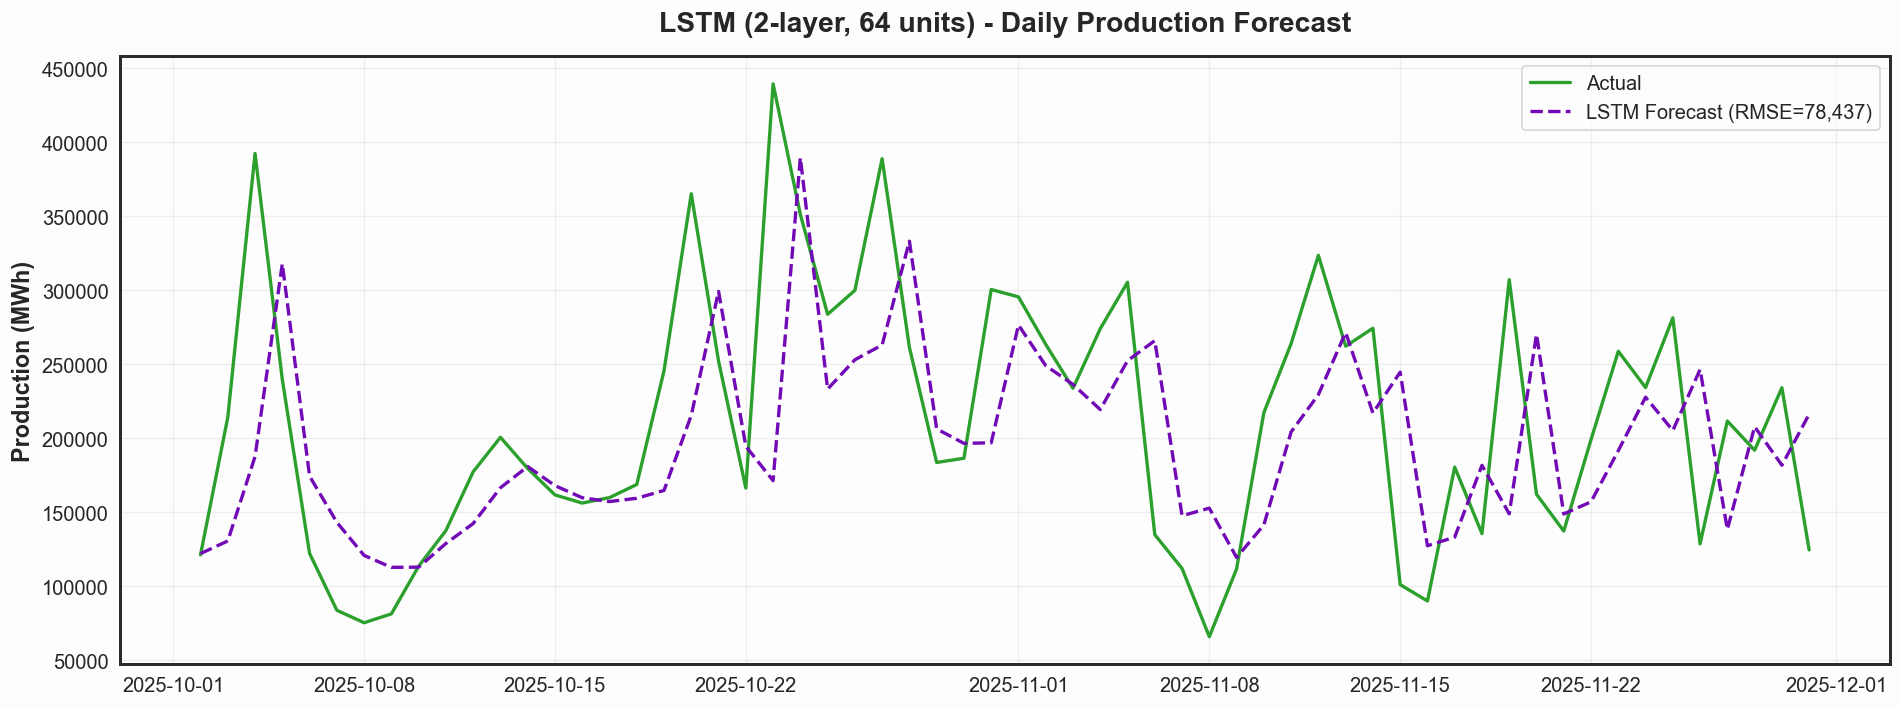

LSTM   -> RMSE: 78,437  |  MAE: 58,277
LSTM model saved to models/lstm_model.h5
Scaler saved to models/scaler.pkl


In [34]:
# LSTM Predictions & Evaluation
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

lstm_rmse = np.sqrt(mean_squared_error(actual_test, lstm_pred))
lstm_mae = mean_absolute_error(actual_test, lstm_pred)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(test.index[:len(actual_test)], actual_test, label="Actual", color="#2ca02c", linewidth=2)
ax.plot(test.index[:len(lstm_pred)], lstm_pred, label=f"LSTM Forecast (RMSE={lstm_rmse:,.0f})",
        color="#7209B7", linewidth=2, linestyle="--")
ax.set_title("LSTM (2-layer, 64 units) - Daily Production Forecast", pad=15)
ax.set_ylabel("Production (MWh)"); ax.legend(fontsize=12); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_23_lstm.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"LSTM   -> RMSE: {lstm_rmse:,.0f}  |  MAE: {lstm_mae:,.0f}")

# Save LSTM model and scaler
lstm_model.save("models/lstm_model.h5")
joblib.dump(scaler, "models/scaler.pkl")
print("LSTM model saved to models/lstm_model.h5")
print("Scaler saved to models/scaler.pkl")

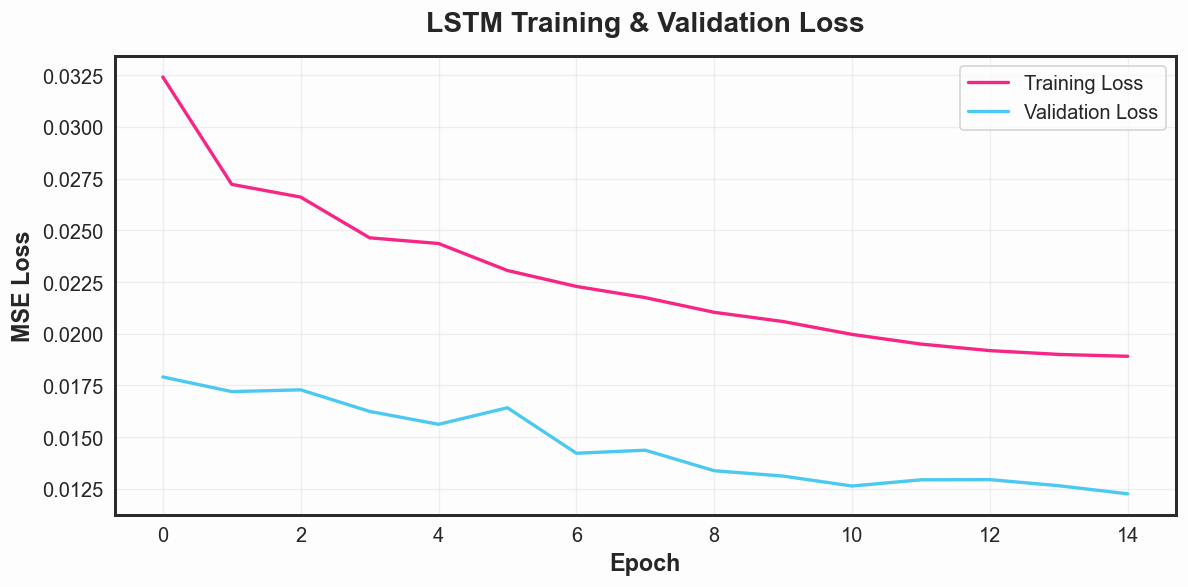

In [35]:
# PLOT 24 - LSTM Training Loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history.history["loss"], label="Training Loss", linewidth=2, color="#F72585")
ax.plot(history.history["val_loss"], label="Validation Loss", linewidth=2, color="#4CC9F0")
ax.set_title("LSTM Training & Validation Loss", pad=15)
ax.set_xlabel("Epoch"); ax.set_ylabel("MSE Loss")
ax.legend(fontsize=12); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("models/plot_24_lstm_loss.png", dpi=150, bbox_inches="tight")
plt.show()

In [36]:
# MODEL COMPARISON TABLE
print("\n" + "=" * 60)
print("  MODEL COMPARISON - Forecasting Performance")
print("=" * 60)
print(f"  {'Model':<15} {'RMSE':>10} {'MAE':>10}")
print(f"  {'-'*15} {'-'*10} {'-'*10}")
print(f"  {'ARIMA(5,1,0)':<15} {arima_rmse:>10,.0f} {arima_mae:>10,.0f}")
print(f"  {'Prophet':<15} {prophet_rmse:>10,.0f} {prophet_mae:>10,.0f}")
print(f"  {'LSTM':<15} {lstm_rmse:>10,.0f} {lstm_mae:>10,.0f}")
print("=" * 60)

# Save comparison results
results = pd.DataFrame({
    "Model": ["ARIMA(5,1,0)", "Prophet", "LSTM"],
    "RMSE": [arima_rmse, prophet_rmse, lstm_rmse],
    "MAE": [arima_mae, prophet_mae, lstm_mae],
})
results.to_csv("models/model_comparison.csv", index=False)
print("\nResults saved to models/model_comparison.csv")

# Save daily time-series for dashboard
df_ts.to_csv("models/daily_production.csv", index=False)
print("Daily production data saved to models/daily_production.csv")


  MODEL COMPARISON - Forecasting Performance
  Model                 RMSE        MAE
  --------------- ---------- ----------
  ARIMA(5,1,0)       144,000    117,678
  Prophet             92,002     72,233
  LSTM                78,437     58,277

Results saved to models/model_comparison.csv
Daily production data saved to models/daily_production.csv


### Key Observation - Forecasting

- **ARIMA** provides a simple baseline but struggles with the complex seasonality of renewable energy data - it tends to converge to a flat mean.
- **Prophet** captures yearly and weekly seasonality well, making it a strong choice for production deployments where interpretability matters.
- **LSTM** can learn non-linear temporal dependencies but requires more data and tuning; its performance depends heavily on the lookback window and network architecture.
- **For production use**, an ensemble of Prophet (for seasonality) and LSTM (for residual patterns) would likely yield the best results.

---

## 14. Saved Model Artifacts

All trained models and data are saved in the `models/` directory:

| File | Description |
|------|-------------|
| `arima_model.pkl` | Fitted ARIMA(5,1,0) model |
| `prophet_model.pkl` | Fitted Prophet model |
| `lstm_model.h5` | Trained LSTM Keras model |
| `scaler.pkl` | MinMaxScaler for LSTM |
| `model_comparison.csv` | RMSE/MAE comparison table |
| `daily_production.csv` | Daily aggregated time-series data |

> These artifacts will be used to build the **interactive forecasting dashboard** in the next phase.